# 소득 예측 AI 해커톤
- `알고리즘`, `정형`, `회귀`, `사회`, `RMSE`
- 기간
    - 2024.03.11 ~ 2024.04.08 09:59
- https://dacon.io/competitions/official/236230/data

## 배경

> 안녕하세요!
>
> 해커톤 41회, 소득 예측 AI 해커톤에 오신 것을 환영합니다.  
> 
> 이번 데이콘 해커톤은 다양한 개인적 특성을 바탕으로 한 데이터를 활용하여 소득 수준을 예측하는 것을 목표로 합니다.
> 
> 참가자 여러분들은 제공된 개인 특성 데이터를 기반으로 한 알고리즘 개발을 통해 
> 
> 개인의 소득 수준을 예측함으로써 사회적 문제 해결에 기여할 수 있는 기회가 될 것입니다. 
> 
> 또한, 이번 대회의 목표는 단순히 개인 소득 수준을 예측하는 것을 넘어, 
> 
> 다양한 개인적 특성 데이터를 분석하고 이해하는 능력을 키우며,
> 
> 이를 통해 AI 역량과 경험을 한 단계 더 발전시키는 것입니다. 




## 주제
- 개인 특성 데이터를 활용하여 개인 소득 수준을 예측하는 AI 모델 개발

## 설명
- 개인의 특성과 관련된 다양한 데이터를 활용하여 개인 소득 수준을 예측할 수 있는 AI 모델 개발

### 컬럼 설명
- `train.csv`
    - 한 사람에 관련된 다양한 사회적, 경제적 정보
    - `ID`: 학습 데이터 고유 ID
    - `Age` : 나이
    - `Gender` : 성별
    - `Education_Status` : 교육 수준
    - `Employment_Status` : 고용 형태
    - `Working_Week (Yearly)` : 연간 근무하는 주
    - `Industry_Status` : 고용 분야
    - `Occupation_Status` : 직업 형태
    - `Race` : 인종
    - `Hispanic_Origin` : 히스패닉 혈통
    - `Martial_Status` : 결혼 유무
    - `Household_Status` : 가정 세대원 상태
    - `Household_Summary` : 가정 세대원 상태 요약
    - `Citizenship` : 시민권
    - `Birth_Country` : 출생국가
    - `Birth_Country (Father)`
    - `Birth_Country (Mother)`
    - `Tax_Status` : 세금 형태
    - `Gains` : 소득 금액
    - `Losses` : 손실 금액
    - `Dividends` : 배당 금액
    - `Income_Status` : 최종 소득 상태
    - `Income` : 예측 목표, 1시간 단위의 소득을 예측 (0일 경우 근로소득이 없다)
- `test.csv`
    - 한 사람에 관련된 다양한 사회적, 경제적 정보
    - `ID` : 테스트 데이터 고유 ID
    - Income이 존재하지 않음
- `sample_submission.csv`
    - `ID` : 테스트 데이터 고유 ID
    - `Income` : ID에 해당되는 Income을 예측하여 제출

# EDA

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None) # 데이터프레임 모든 열 출력

from datetime import datetime
from datetime import timedelta
import missingno as msno

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings(action='ignore')

In [24]:
df_path = "data/cramer_preprocessed.csv"
df = pd.read_csv(df_path)
df.head()

age gender   education_status  working_week (yearly)  \
0   63      M       Middle (7-8)                      4   
1   37      M  Associates degree                     52   
2   58      F      High graduate                     52   
3   44      M      High graduate                     52   
4   37      F      High graduate                     52   

                  occupation_status   race hispanic_origin household_summary  \
0                          Services  White       All other       Householder   
1                          Services  White       All other       Householder   
2  Admin Support (include Clerical)  Black       All other       Householder   
3             Technicians & Support  White       All other       Householder   
4                             Sales  White       All other       Householder   

  citizenship                                   tax_status income_status  \
0      Native                                     Nonfiler       Unknown   
1      Native                                       Single  Under Median   
2      Native  Married Filling Jointly both under 65 (MFJ)  Under Median   
3      Native                                       Single  Under Median   
4      Native                      Head of Household (HOH)       Unknown   

   income  
0   425.0  
1     0.0  
2   860.0  
3   850.0  
4   570.0

## 결측치 확인

In [25]:
df.isnull().sum()

# income 컬럼에서 결측치 10000개 확인
# test 데이터셋의 income컬럼이 결측치로 되어있어서 결측치 10000개로 관측
# 예측해야하는 값이기 때문에 따로 결측치 처리 하지 않음 (EDA 이후 train, test 데이터셋 분리 예정)

age                          0
gender                       0
education_status             0
working_week (yearly)        0
occupation_status            0
race                         0
hispanic_origin              0
household_summary            0
citizenship                  0
tax_status                   0
income_status                0
income                   10000
dtype: int64

## 이상치 확인
- 수치형 변수들로 `boxplot` 그려본다

In [26]:
num_cols = df.select_dtypes(include="number").columns.tolist()

print(num_cols)
print(len(num_cols))

['age', 'working_week (yearly)', 'income']
3


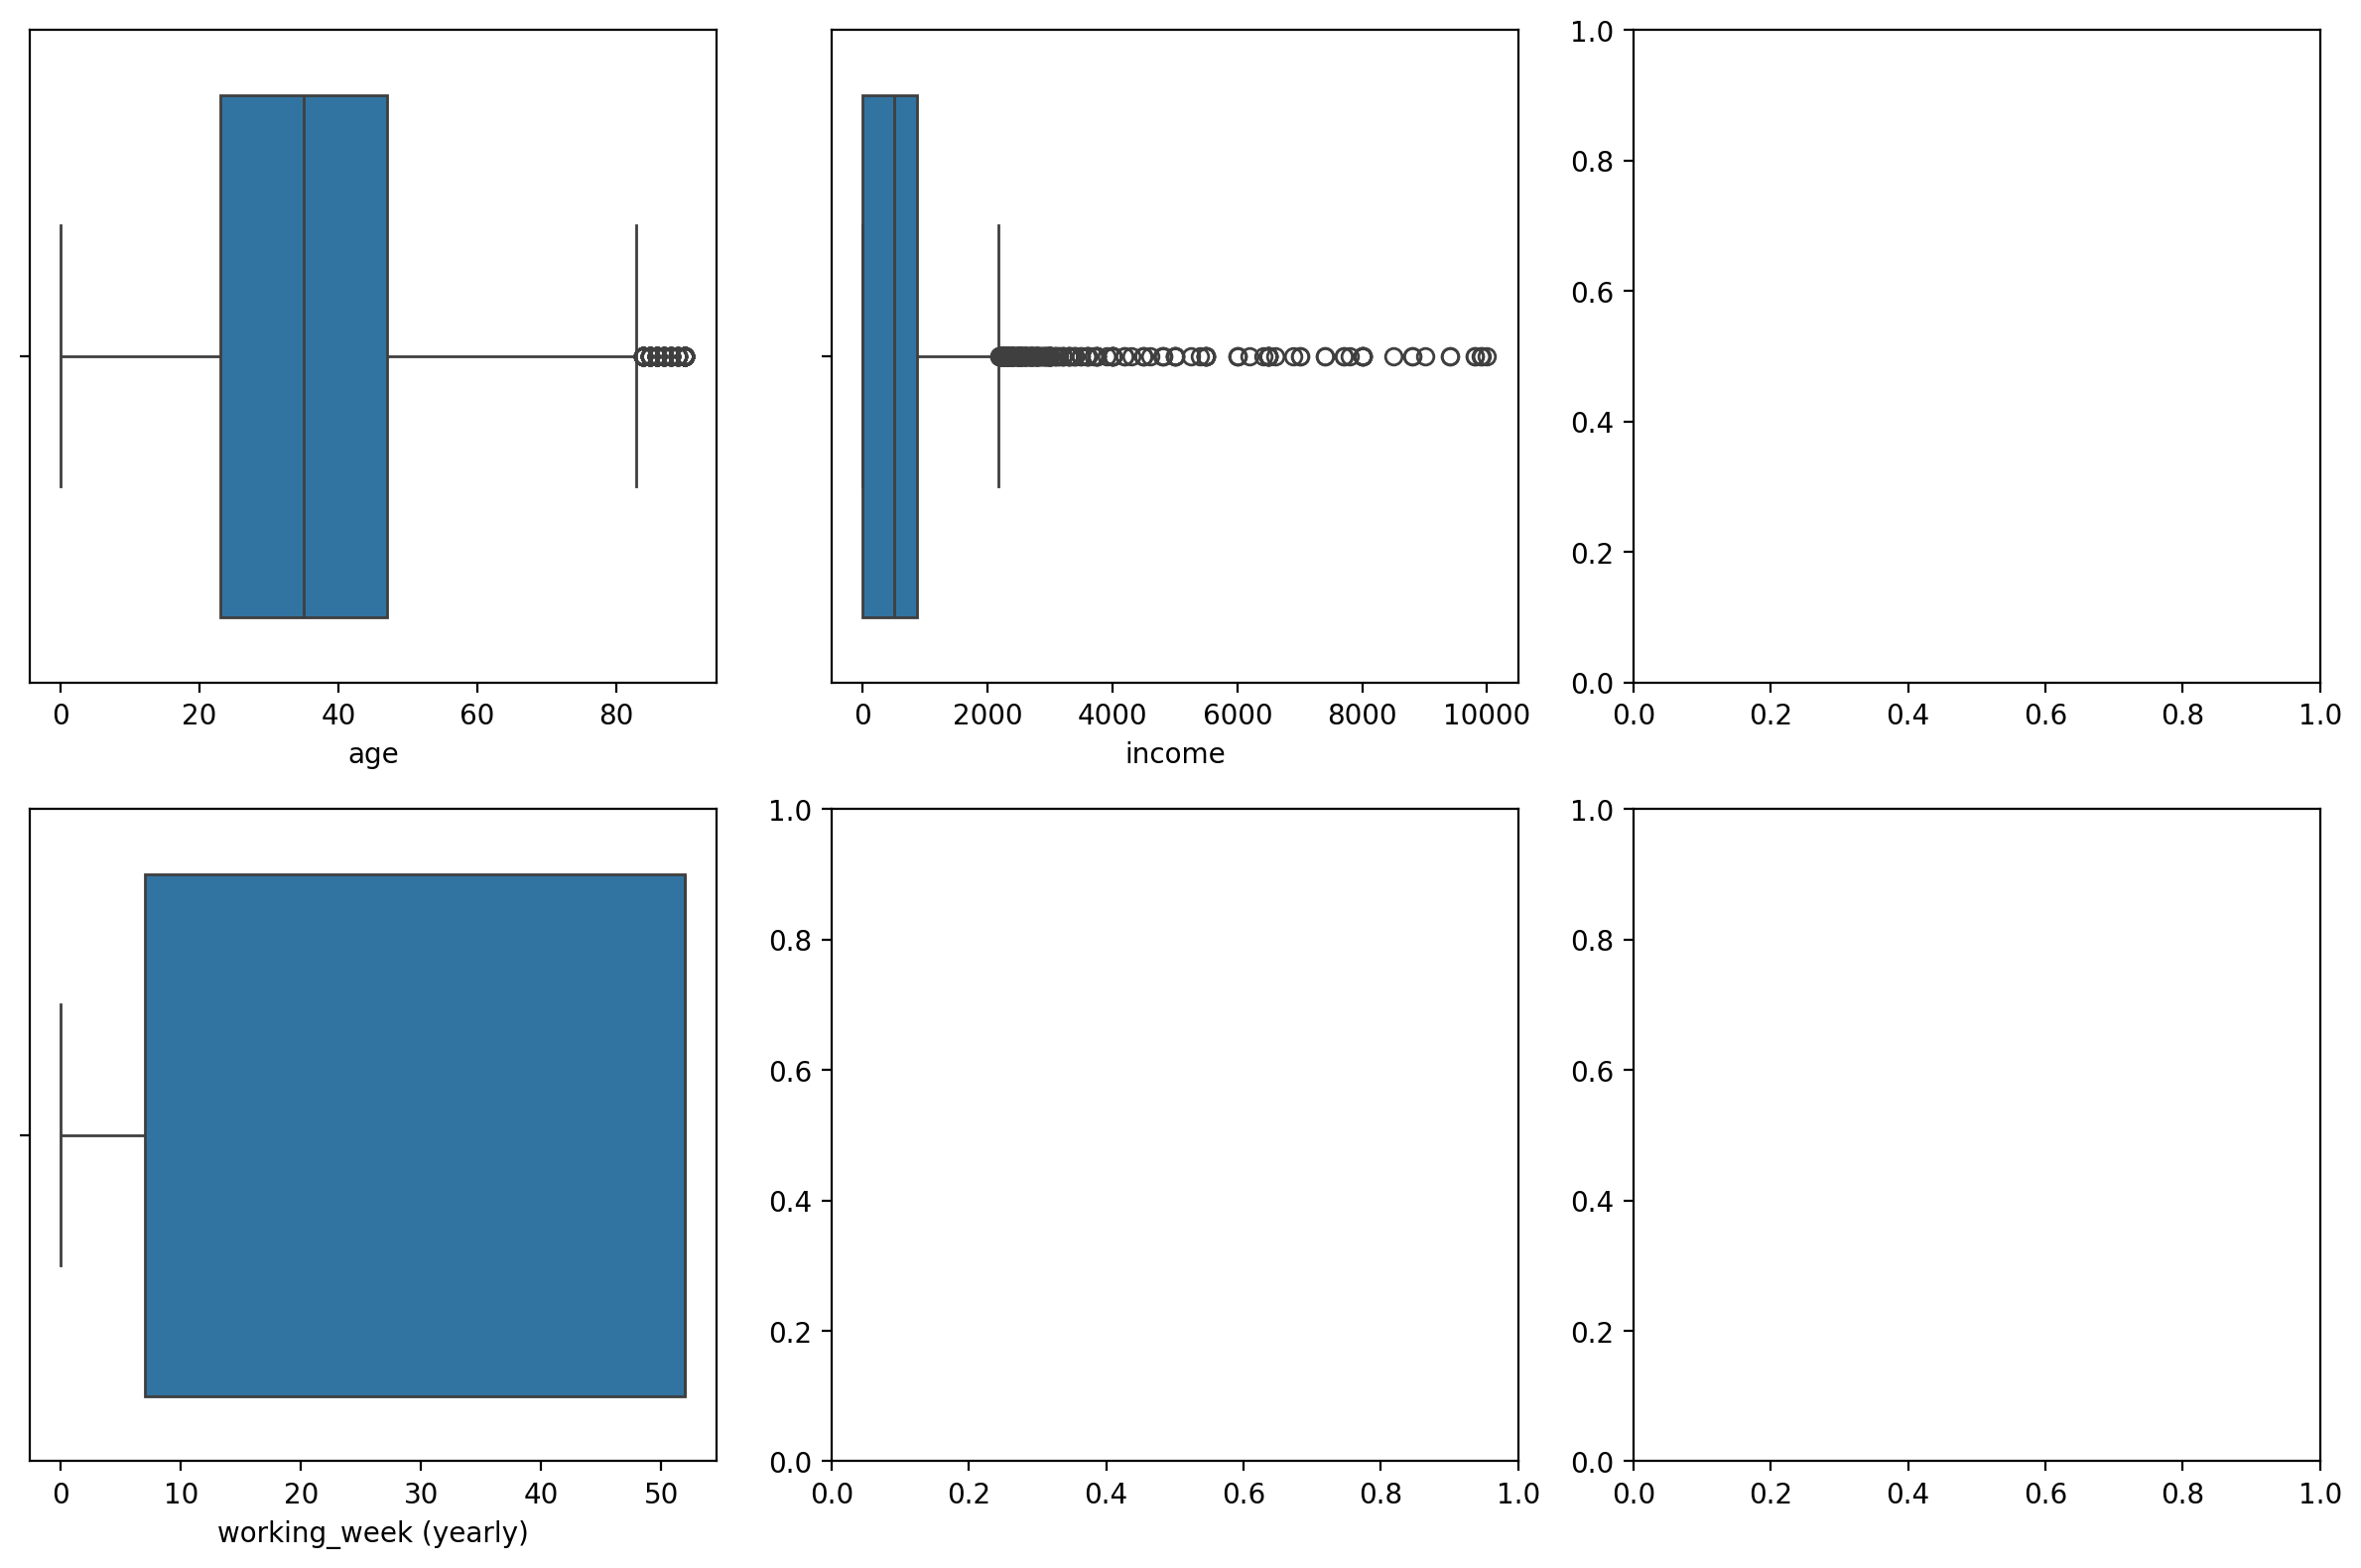

In [27]:
# subplot 생성
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(num_cols, axes):
    sns.boxplot(data=df, x=col, ax=ax)
    # sns.stripplot(data=df, x=col, ax=ax, y="last_season", hue="foot")

fig.tight_layout()
plt.show()

### 이상치 확인 결과
- `gains`, `diviends`, `losses`, `income`에서 이상치 다수 존재
    - 데이터에 0이 너무 많아서 이상치가 많이 잡힌다
- 처리 방안 고민 필요

## Pairplot 확인

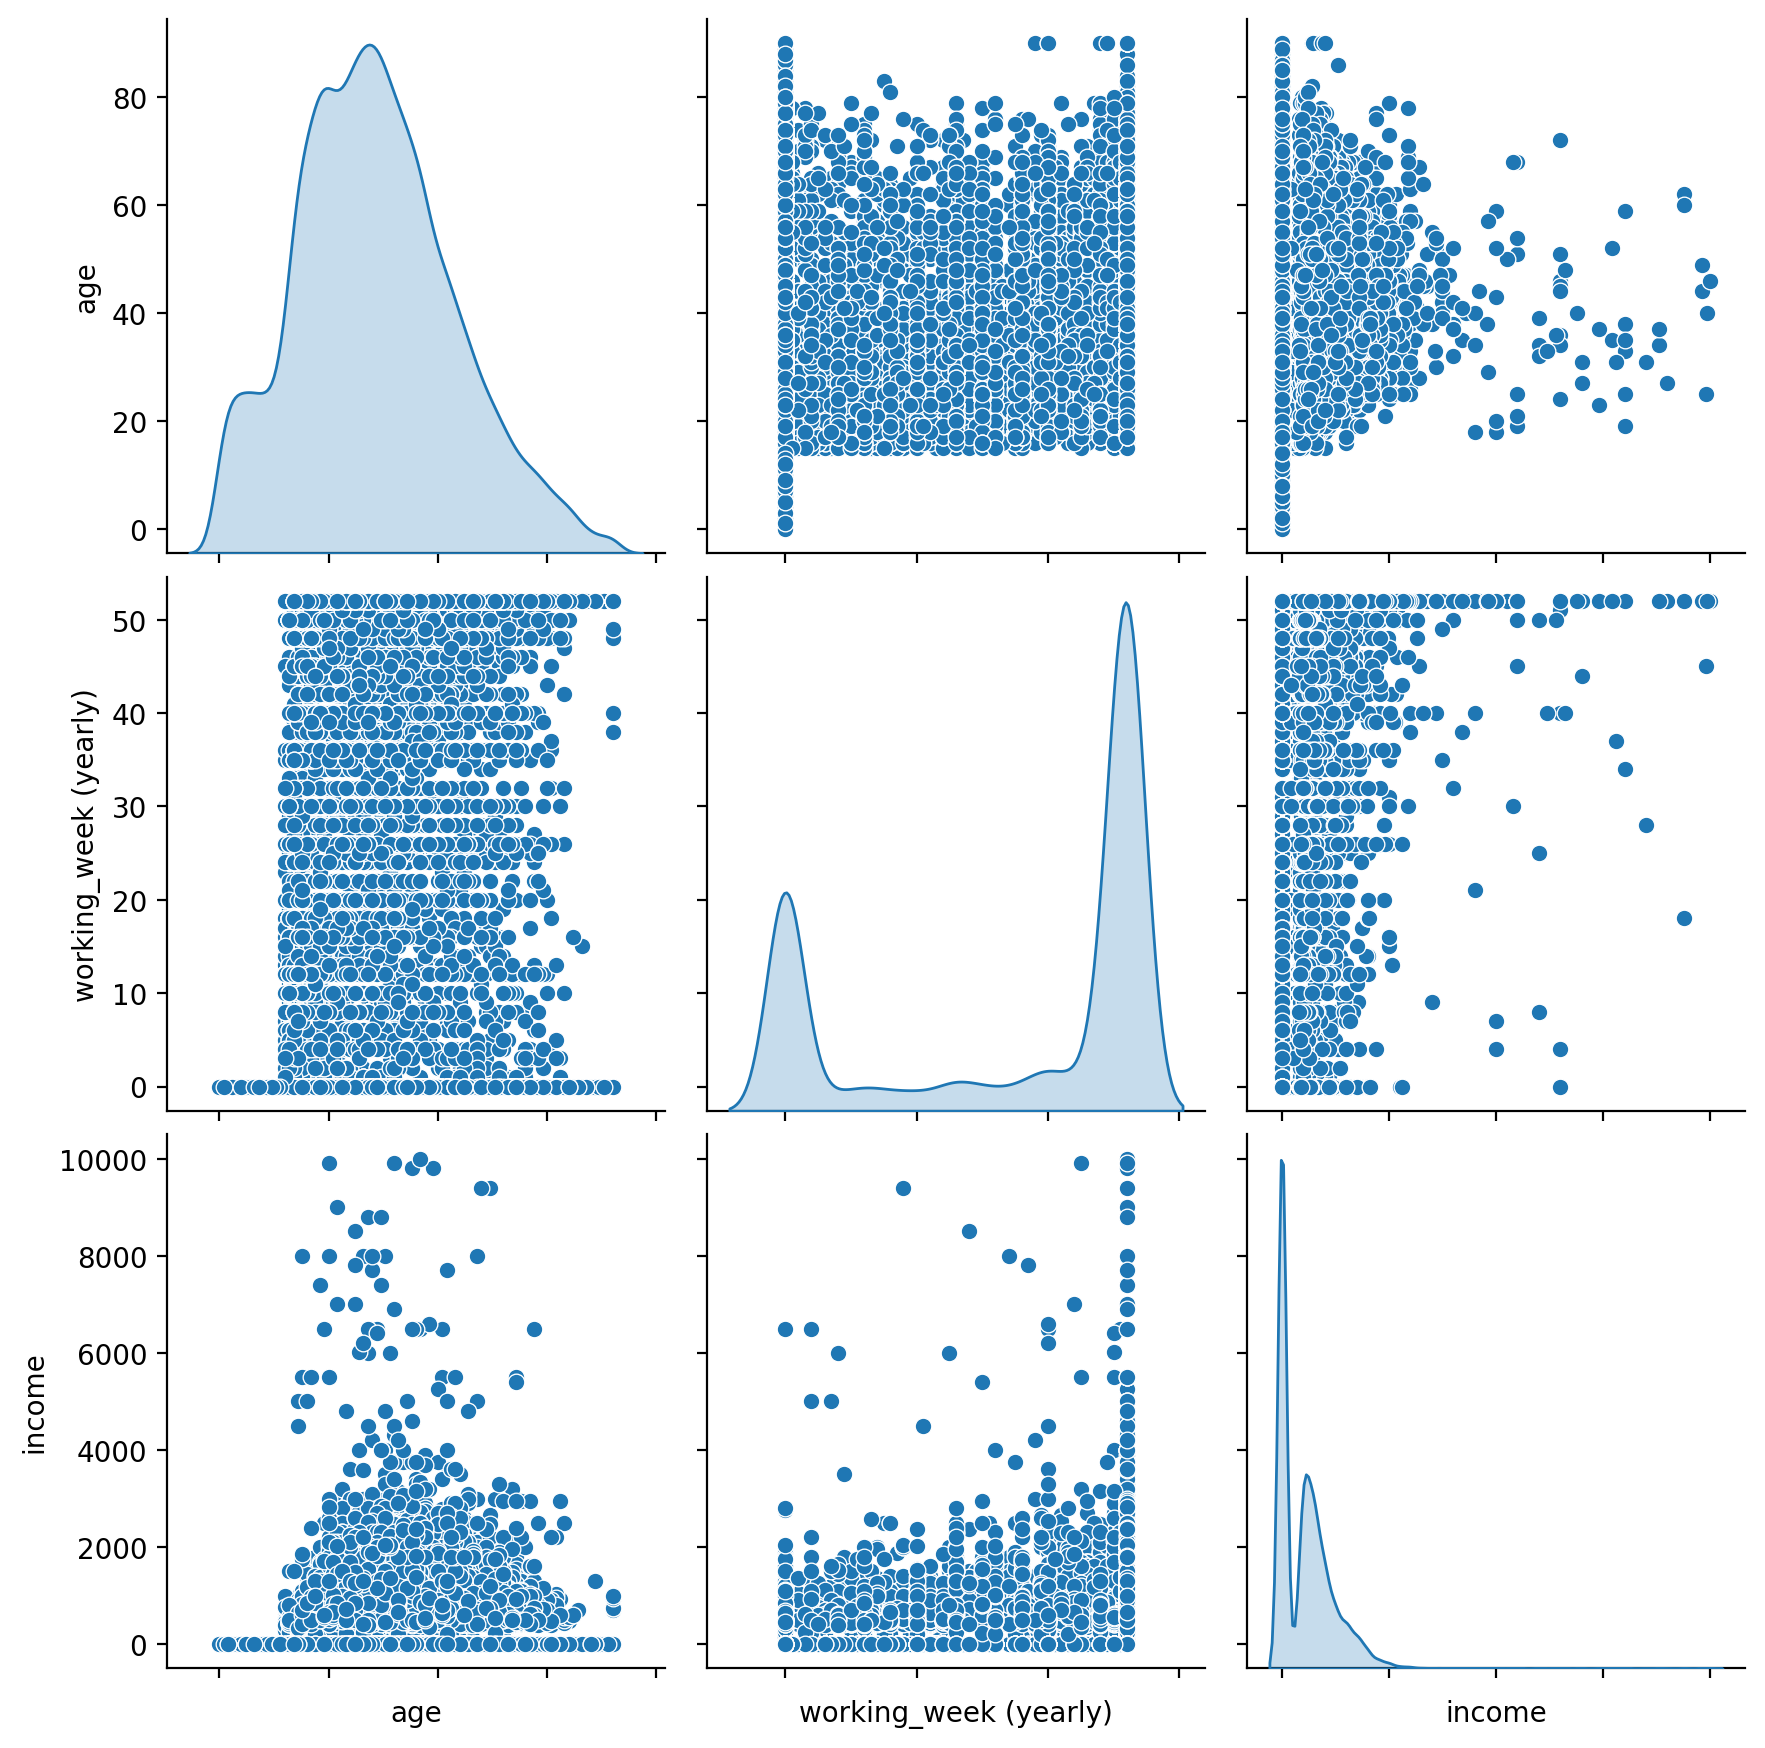

In [28]:
g = sns.pairplot(df, palette = 'seismic', diag_kind = 'kde', size=3)
g.set(xticklabels=[])

In [29]:
df_corr = df[num_cols].corr()

df_corr.style.background_gradient()

<Axes: >

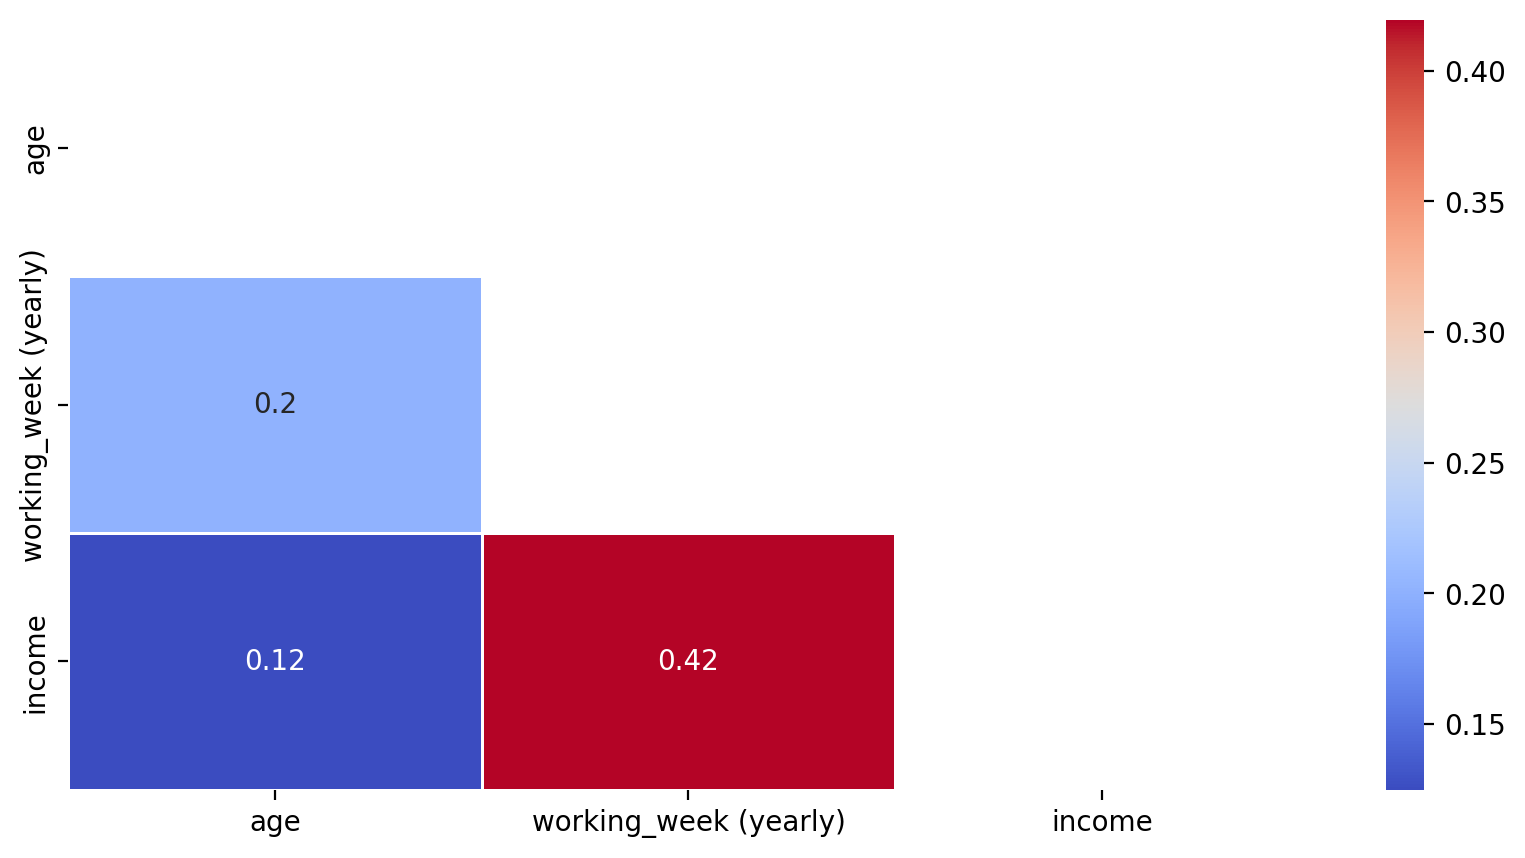

In [30]:
plt.figure(figsize=(10,5))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')

### 상관관계 결과
- 뚜렷한 상관관계 (0.4 ~ 0.6)
    - `income` - `working_week (yearly)`
- 약한 상관관계 (0.2 ~ 0.6)
    - `age` - `working_week (yearly)`

## 다중 공선성
- 하나의 독립 변수가 여러개의 독립 변수들로 잘 예측되는 경우를 의미한다
- 독립 변수들이 서로 독립이 아니라, 상호 상관관계가 강한 경우 발생
- 일반적으로 어떤 독립 변수의 영향력을 파악할 때, 확인하려는 변수의 영향력만을 판단하기 위해 다른 독립 변수들은 모두 일정하다고 가정한다.
- 그러나 만약 두 독립 변수가 서로에게 영향을 주고 있다면, 하나의 영향력을 검증할 때 다른 하나의 영향력을 완전히 통제할 수 없게 된다
    - 이러한 상황에서는 도출된 해석이 타당하다고 볼 수 없다
    
- 다중 공선성이 존재한다면 모델 구축 시 발생하는 상황
    - 계수 추정이 잘 되지 않거나, 불안정해져서 데이터가 약간만 바뀌어도 추정치 크게 달라짐
    - 계수가 통계적으로 유의미하지 않은 것처럼 도출
    - 과적합의 위험성
    - 특히 회귀 분석에 큰 영향 미친다 (분류는 영향 크게 미칠때도 있고 별로 상관 없을 때도 있음)
- References
    - https://dacon.io/codeshare/4443
    - https://datascienceschool.net/03%20machine%20learning/06.04%20%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC%20%EB%B3%80%EC%88%98%20%EC%84%A0%ED%83%9D.html
    - https://dacon.io/forum/408387

### 다중 공선성 진단
- 분산팽창계수 (VIF, Variance Inflation Factor)를 구한다
- 일반적으로 5 또는 10보다 크면 다중 공선성이 있다고 판단한다

- VIF : 독립변수를 다른 독립변수로 선형회귀한 성능을 나타낸 지표
    - 다른 변수에 의존적일 수록 VIF가 증가

In [31]:
num_cols

['age', 'working_week (yearly)', 'income']

In [32]:
# 출처 : https://aliencoder.tistory.com/17

# num_cols에서 target 컬럼 뺀 값을 num_cols_no_target에 리스트로 선언
num_cols_no_target = df.drop(columns="income").select_dtypes(include=np.number).columns

def feature_engineering_XbyVIF(df):
    vif = pd.DataFrame()

    # df의 컬럼 개수만큼 variance_inflation_factor를 구한다
    vif['VIF_Factor'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    # df의 컬럼 이름을 vif의 Feature 열에 넣어준다
    vif['Feature'] = df.columns
    return vif

vif = feature_engineering_XbyVIF(df[num_cols_no_target])
print(vif)

   VIF_Factor                Feature
0    2.812965                    age
1    2.812965  working_week (yearly)


### 다중 공선성 해결 방법
- 다중 공선성을 갖는 독립 변수 중 하나 혹은 일부를 제거한다
    - 단 회귀 모형의 R-square 값을 유지 또는 개선시키는 방향으로만 수행해야 한다
- 변수를 변형시키거나 새로운 관측치를 이용한다
- 자료를 수집하는 현장의 상황을 보아 상관관계의 이유를 파악하여 해결한다
- 주성분 분석 (Principle Component Analysis, PCA)을 이용한 diagonal matrix의 형태로 공선성을 없애준다

- References
    - https://aliencoder.tistory.com/17

#### 다중 공선성 결론
- 수치형 변수들의 VIF 수치가 5 미만이므로, 딱히 제거하거나 변형하지 않는다
        

## 분포 확인

### `Target` 분포

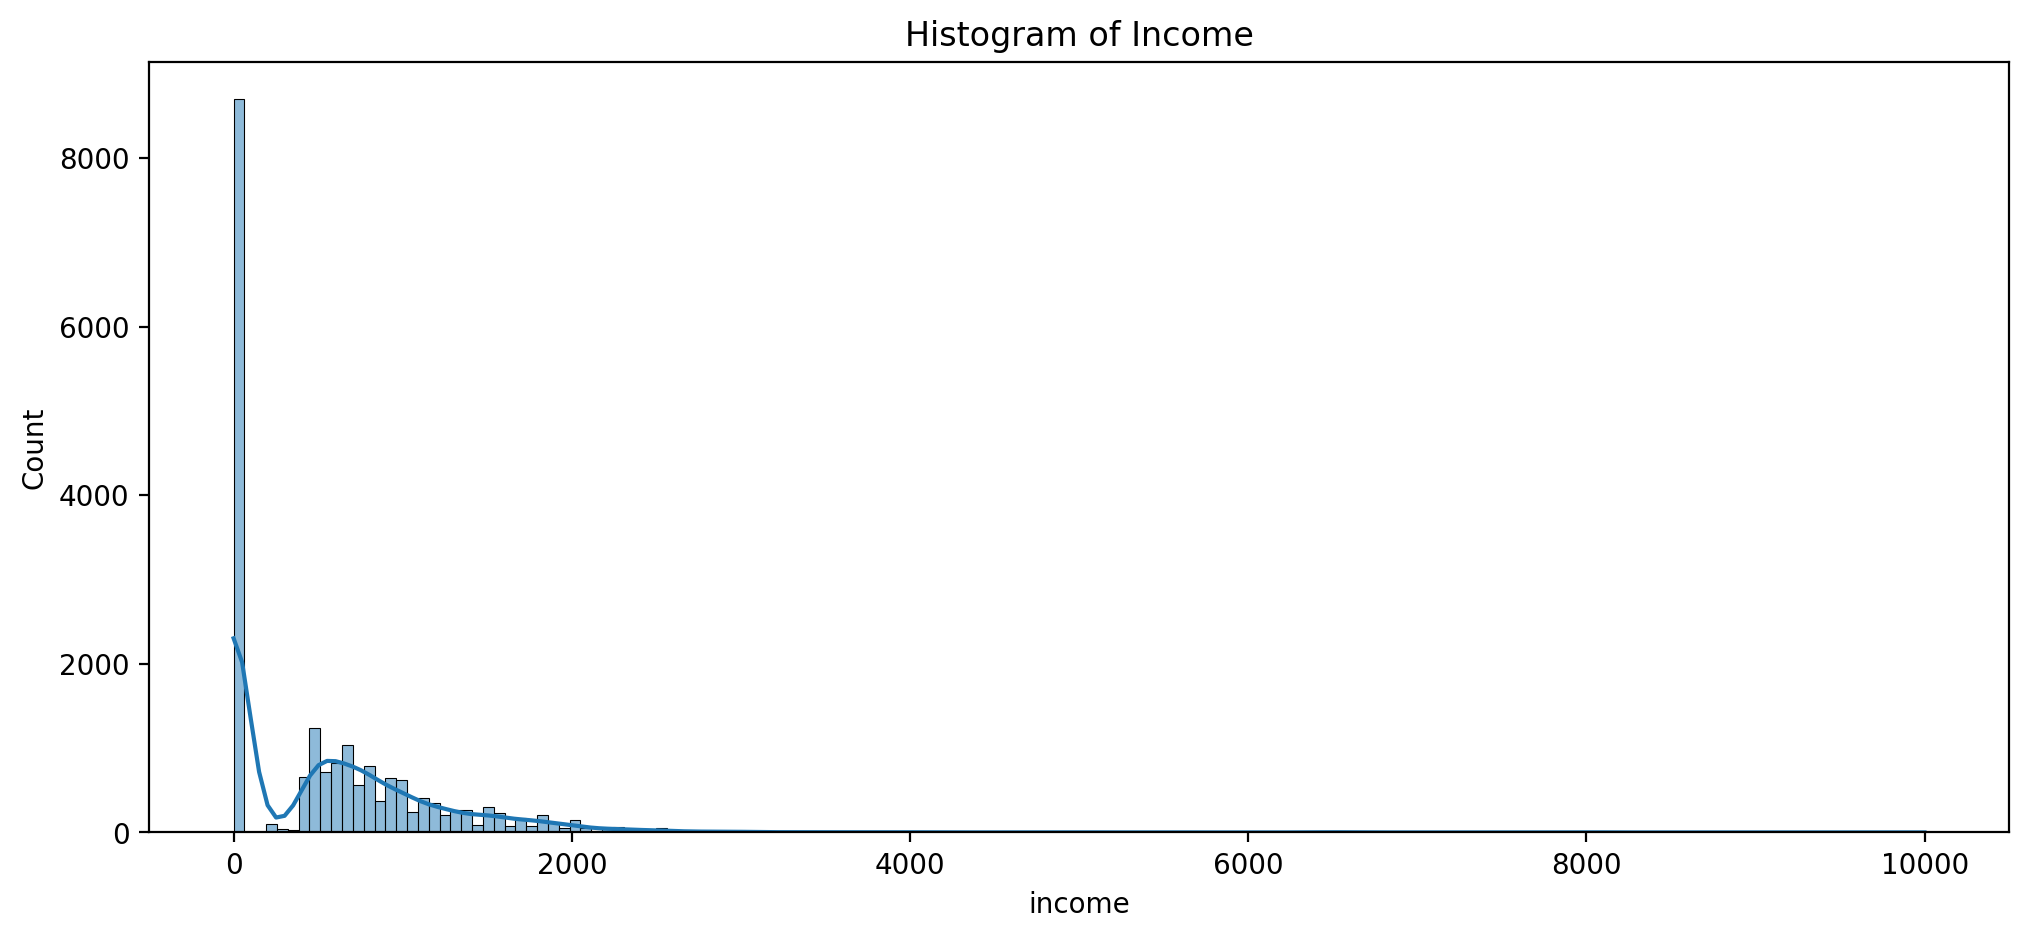

In [33]:
# Income 컬럼 분포 확인
# 0이 너무 많다 → 한쪽으로 치우친 분포 (right skewed)
plt.figure(figsize=(12, 5))
sns.histplot(data=df, x="income", kde=True)
plt.title("Histogram of Income")
plt.show()


### 범주형 변수

In [34]:
# 범주형 변수 리스트
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

# cat_cols에서 id 컬럼은 제거한다
# cat_cols.remove("id")

len(cat_cols)

9

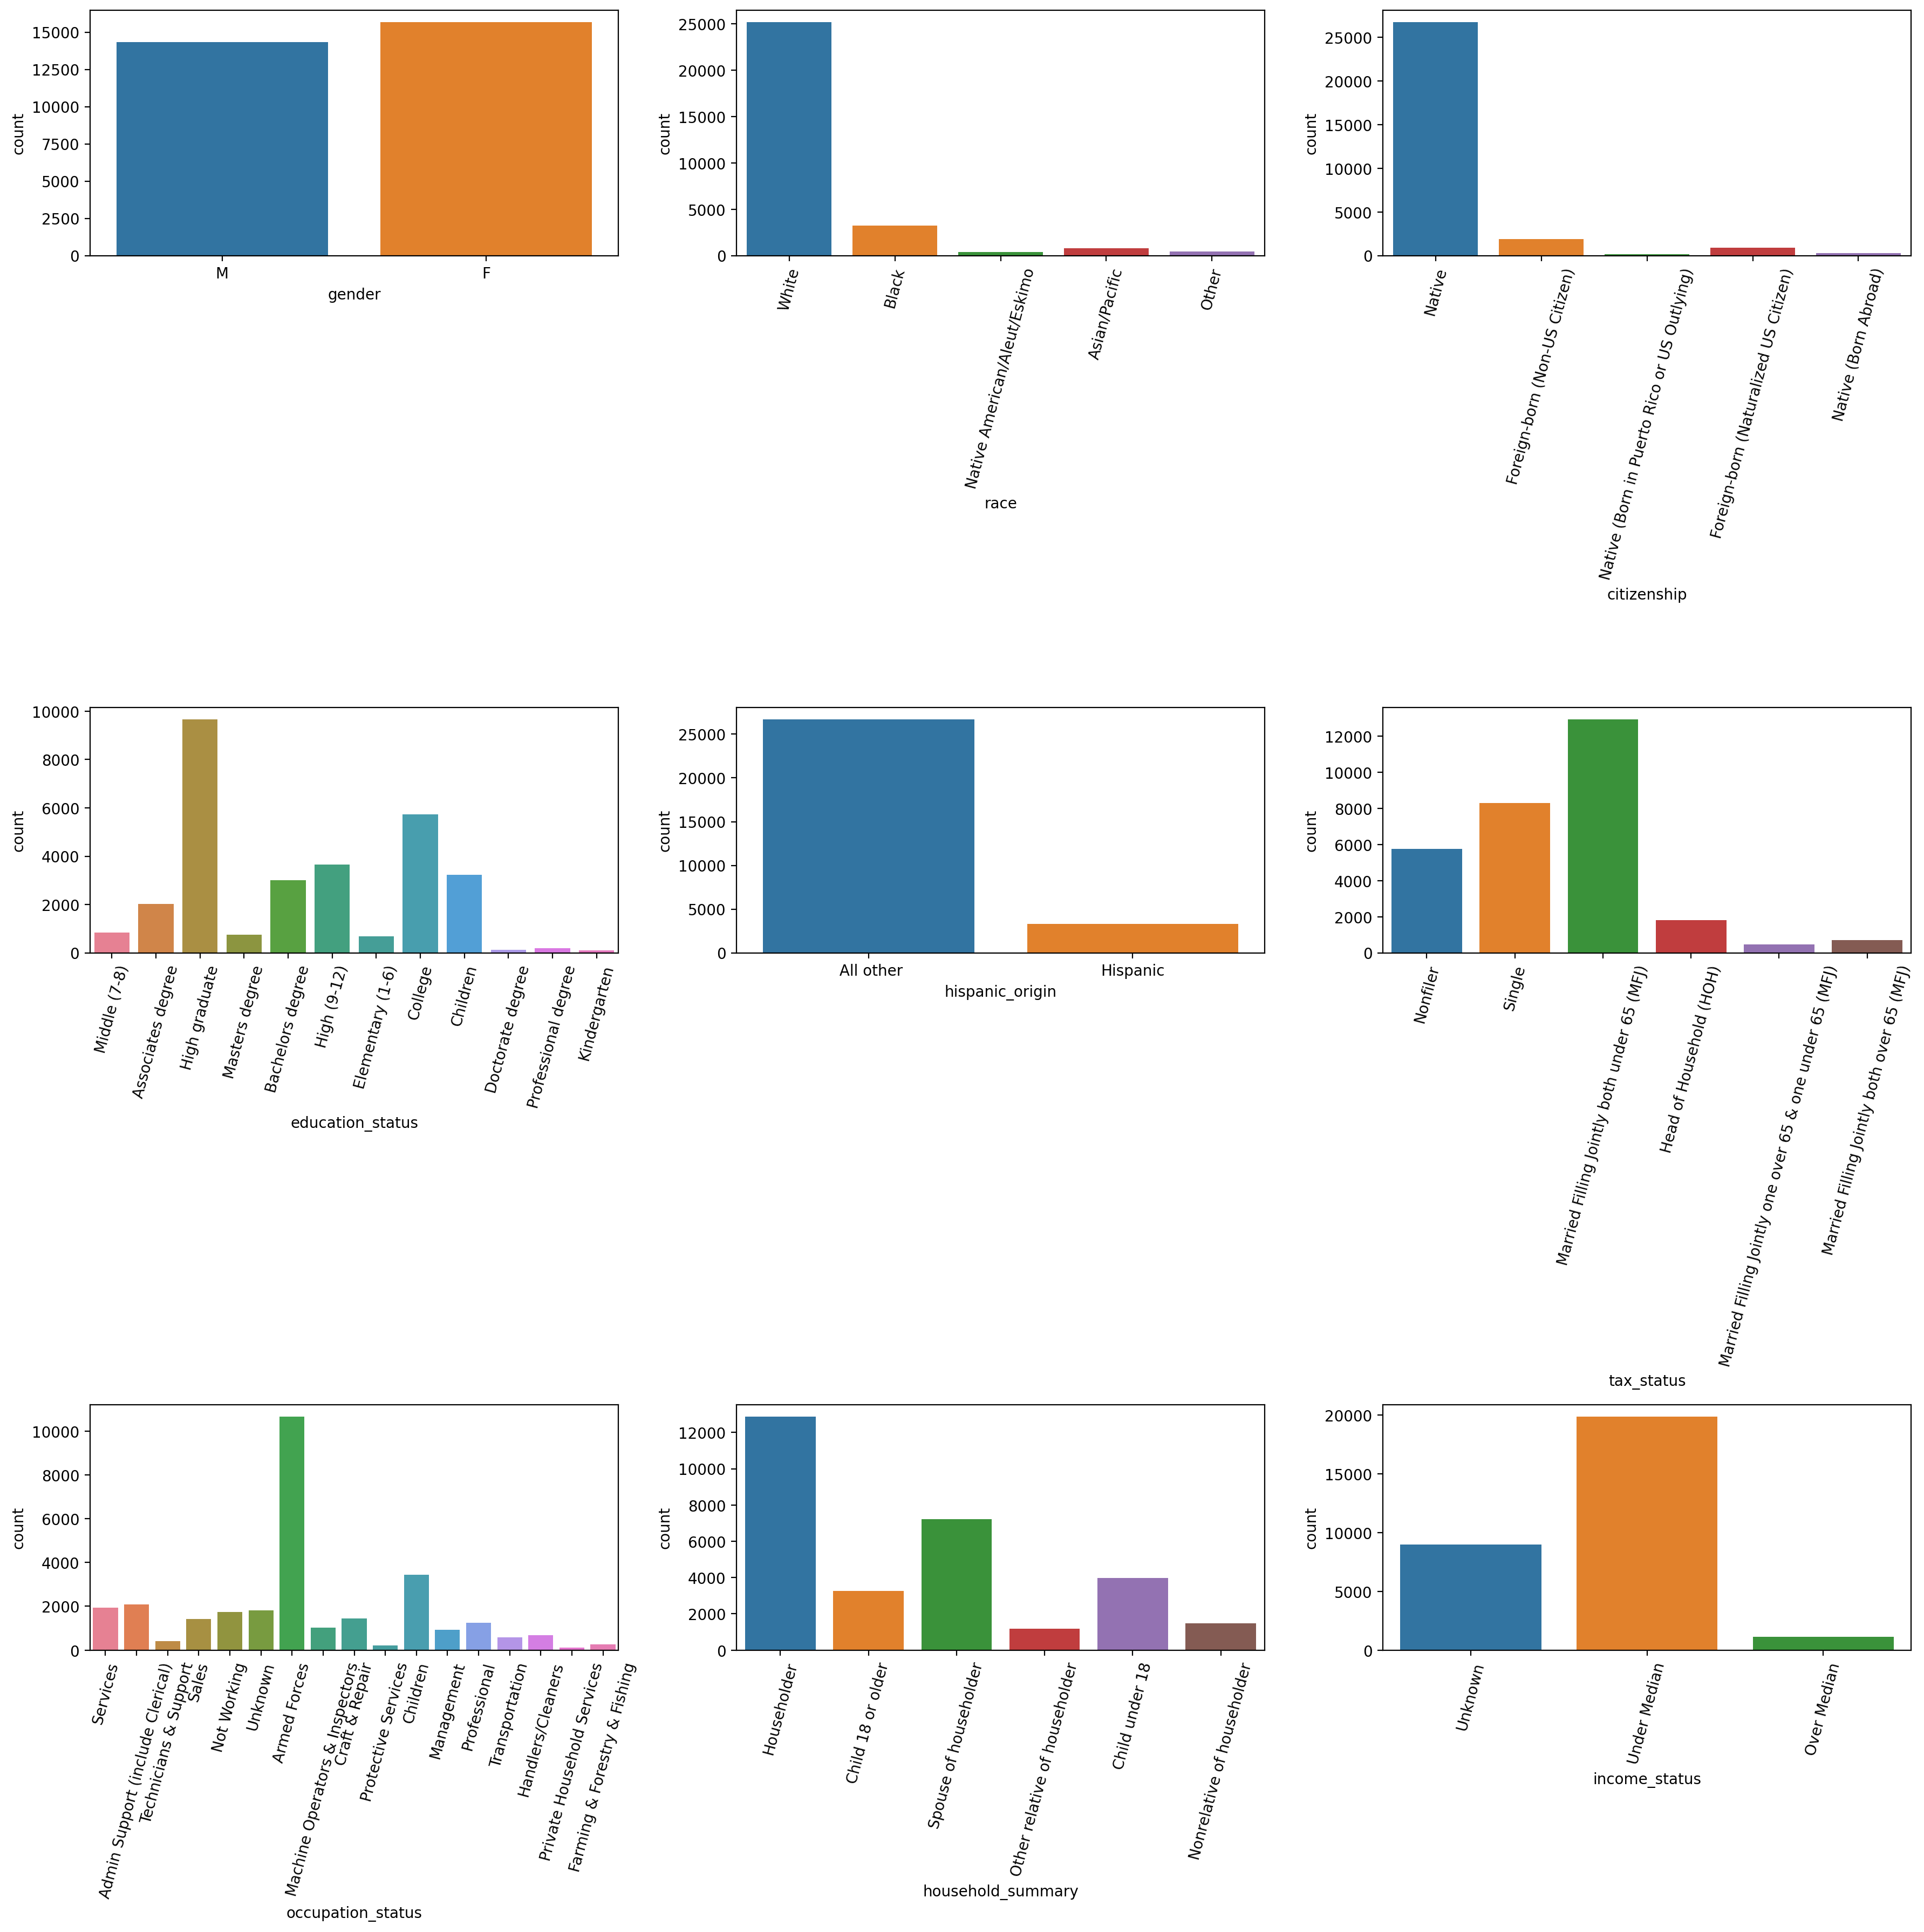

In [35]:
# 범주형 변수 countplot 그려봄
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

# flatten()을 통해axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(cat_cols, axes):
    g = sns.countplot(data=df, x=col, ax=ax, hue=col)

    if df[col].nunique() > 2:
        g.set_xticklabels(g.get_xticklabels(), rotation=75)
    else:
        g.set_xticklabels(g.get_xticklabels())

fig.tight_layout()
plt.show()

### 연속형 변수

In [36]:
num_cols = df.select_dtypes(include="number").columns.tolist()
num_cols

['age', 'working_week (yearly)', 'income']

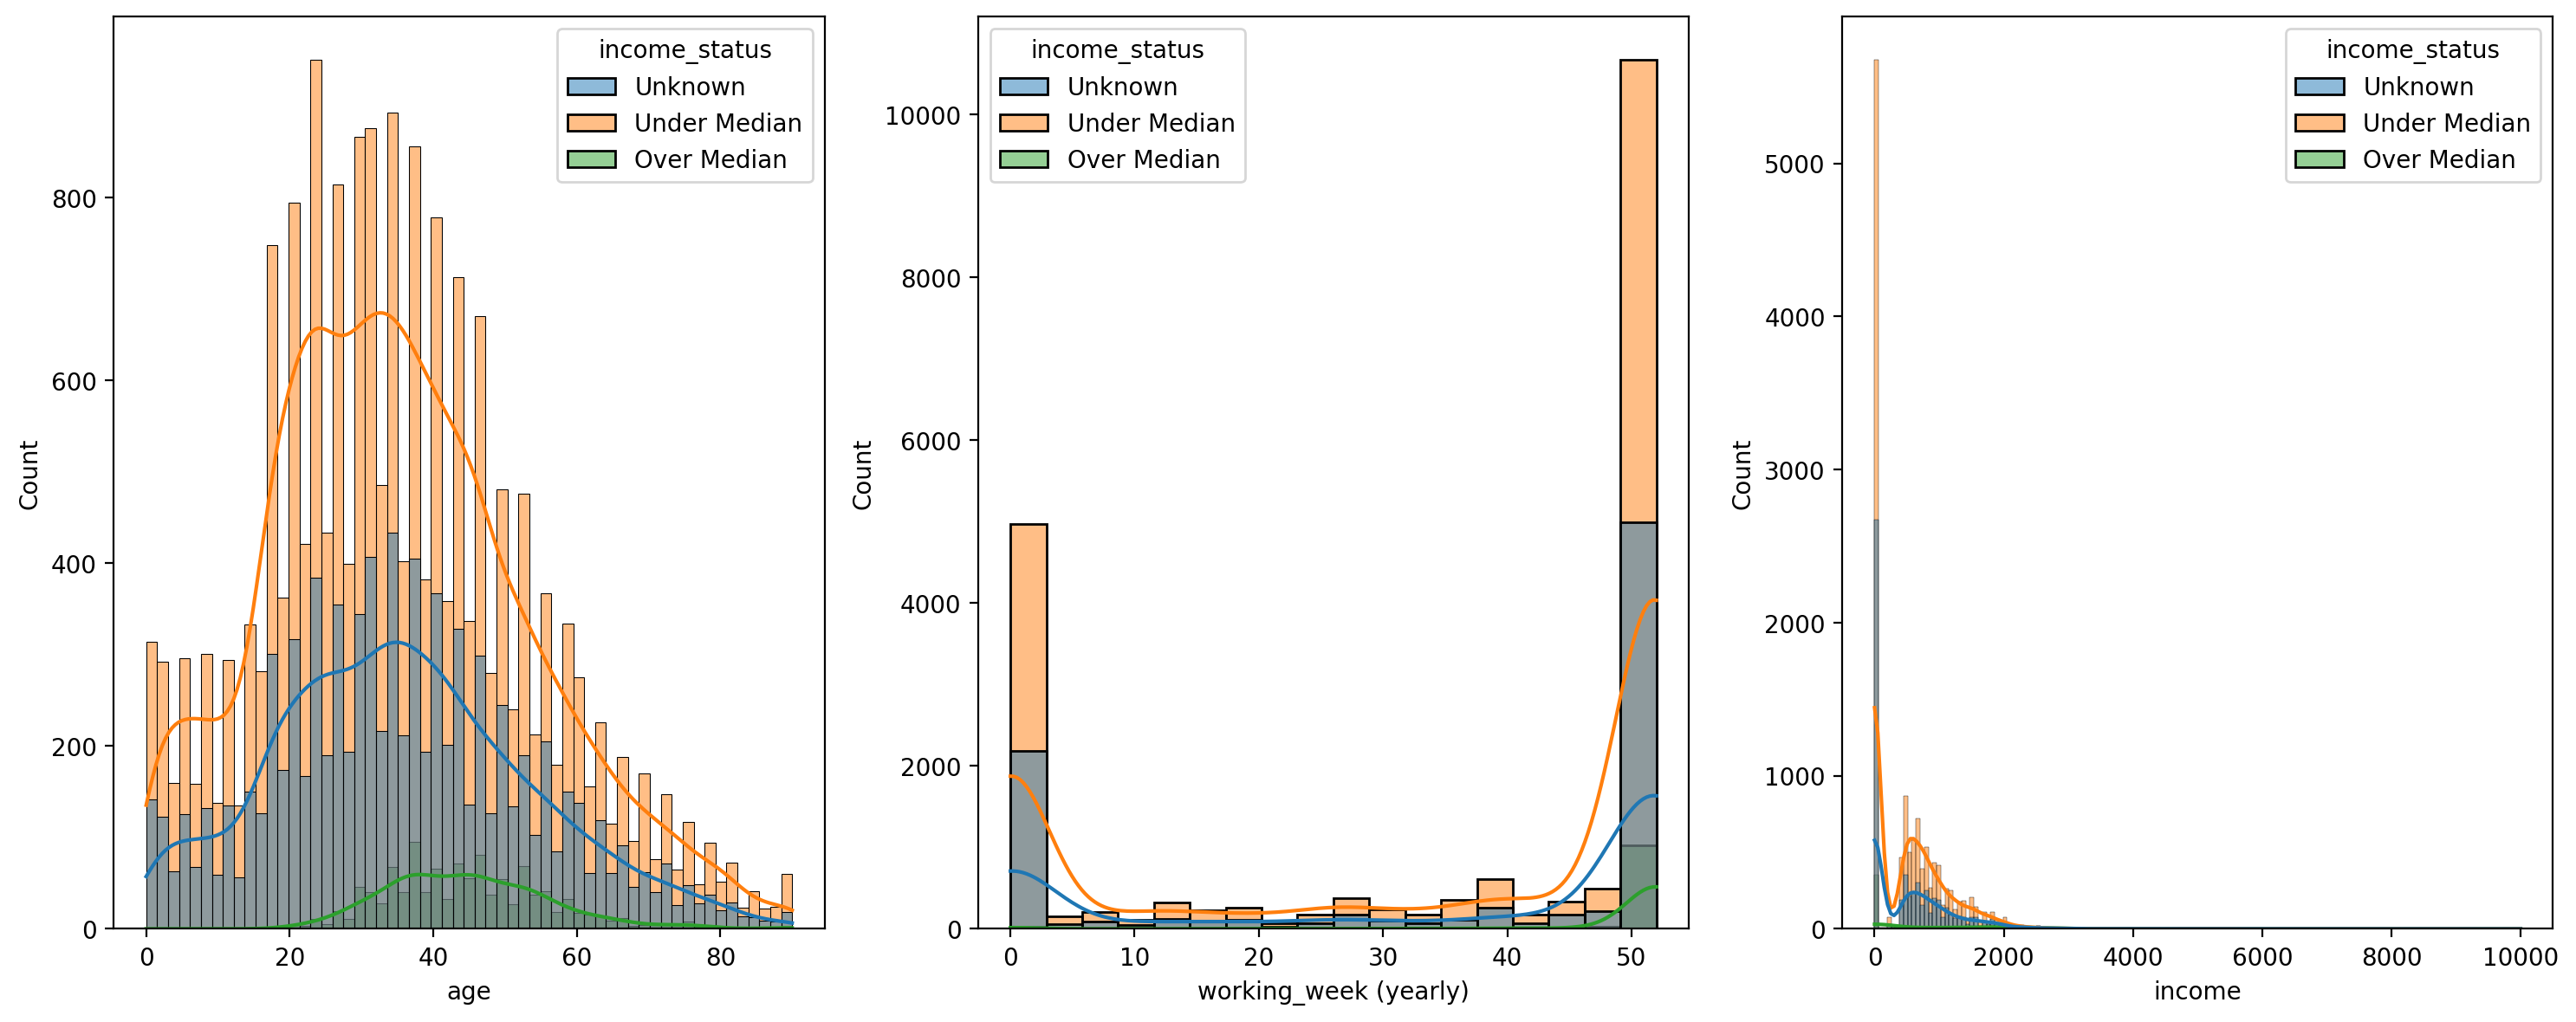

In [49]:
# subplot 생성
nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6))

# flatten()을 통해axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(num_cols, axes):
    sns.histplot(data=df, x=col, ax=ax, kde=True, hue="income_status")

fig.tight_layout()
plt.show()

#### 상관관계 높은 변수들 분포 확인
- 상관관계가 높은 변수 관계 2가지 분포 시각화해본다

In [38]:
# 상관관계 높은 변수들끼리 짝지워 high_corr에 선언
high_corr = {"income" : "working_week (yearly)", 
             "age" : "working_week (yearly)"}
high_corr

{'income': 'working_week (yearly)', 'age': 'working_week (yearly)'}

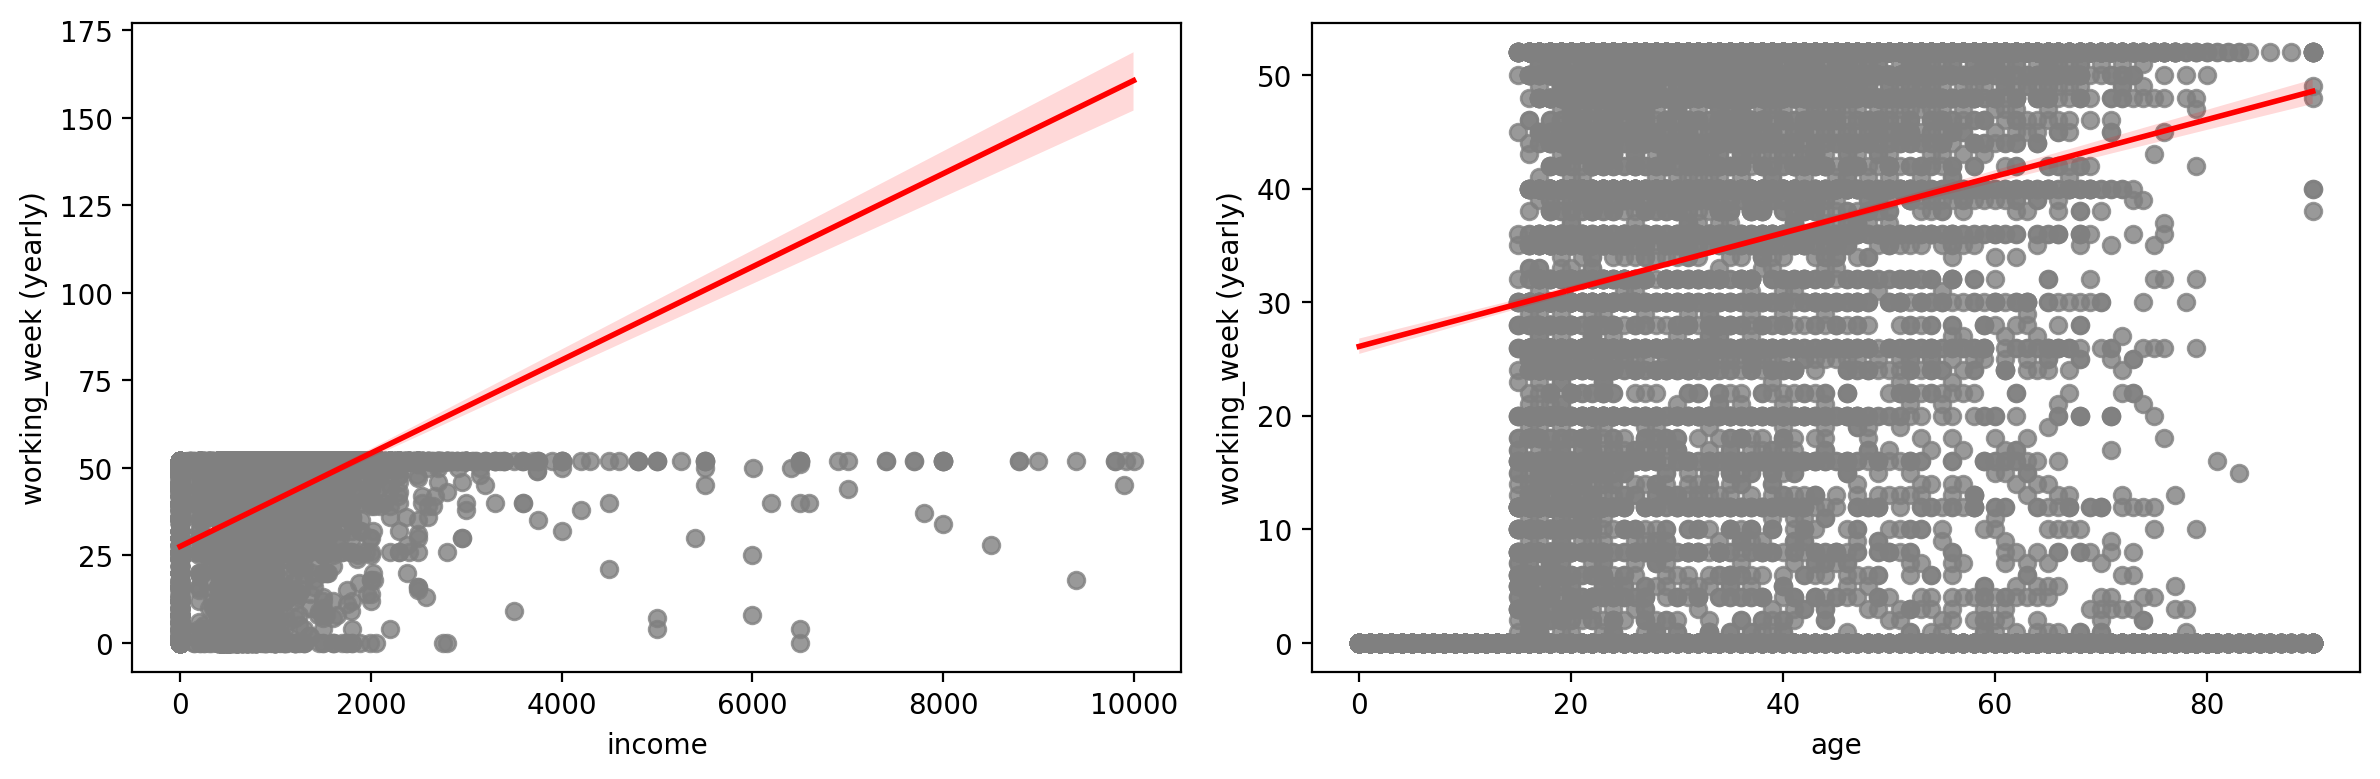

In [39]:
# 상관관계 분포 시각화
# subplot 생성
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

# regplot 그려서 추세선과 상관관계 확인
for key, ax in zip(high_corr, axes):
    sns.regplot(x=df[f"{key}"],
                y=df[high_corr[f"{key}"]],
                ax=ax,
                scatter_kws={"color":"gray"},
                line_kws={"color":"red", "lw":2})

fig.tight_layout()
plt.show()

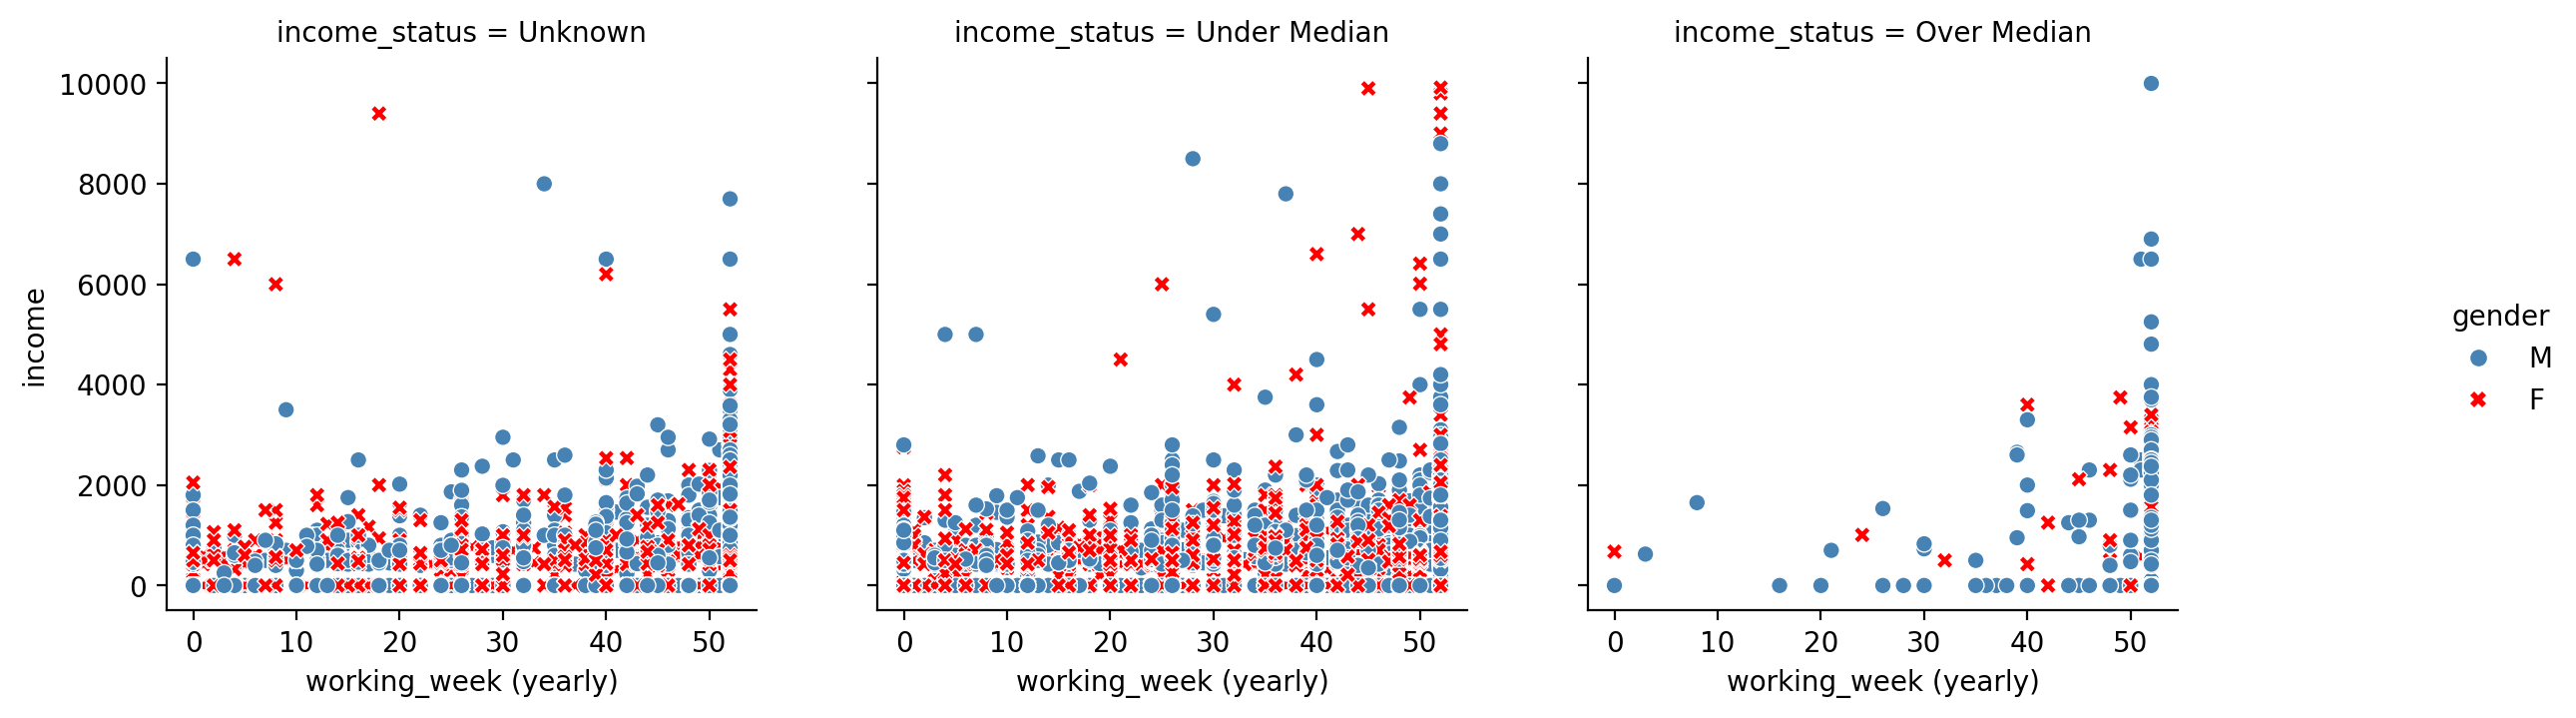

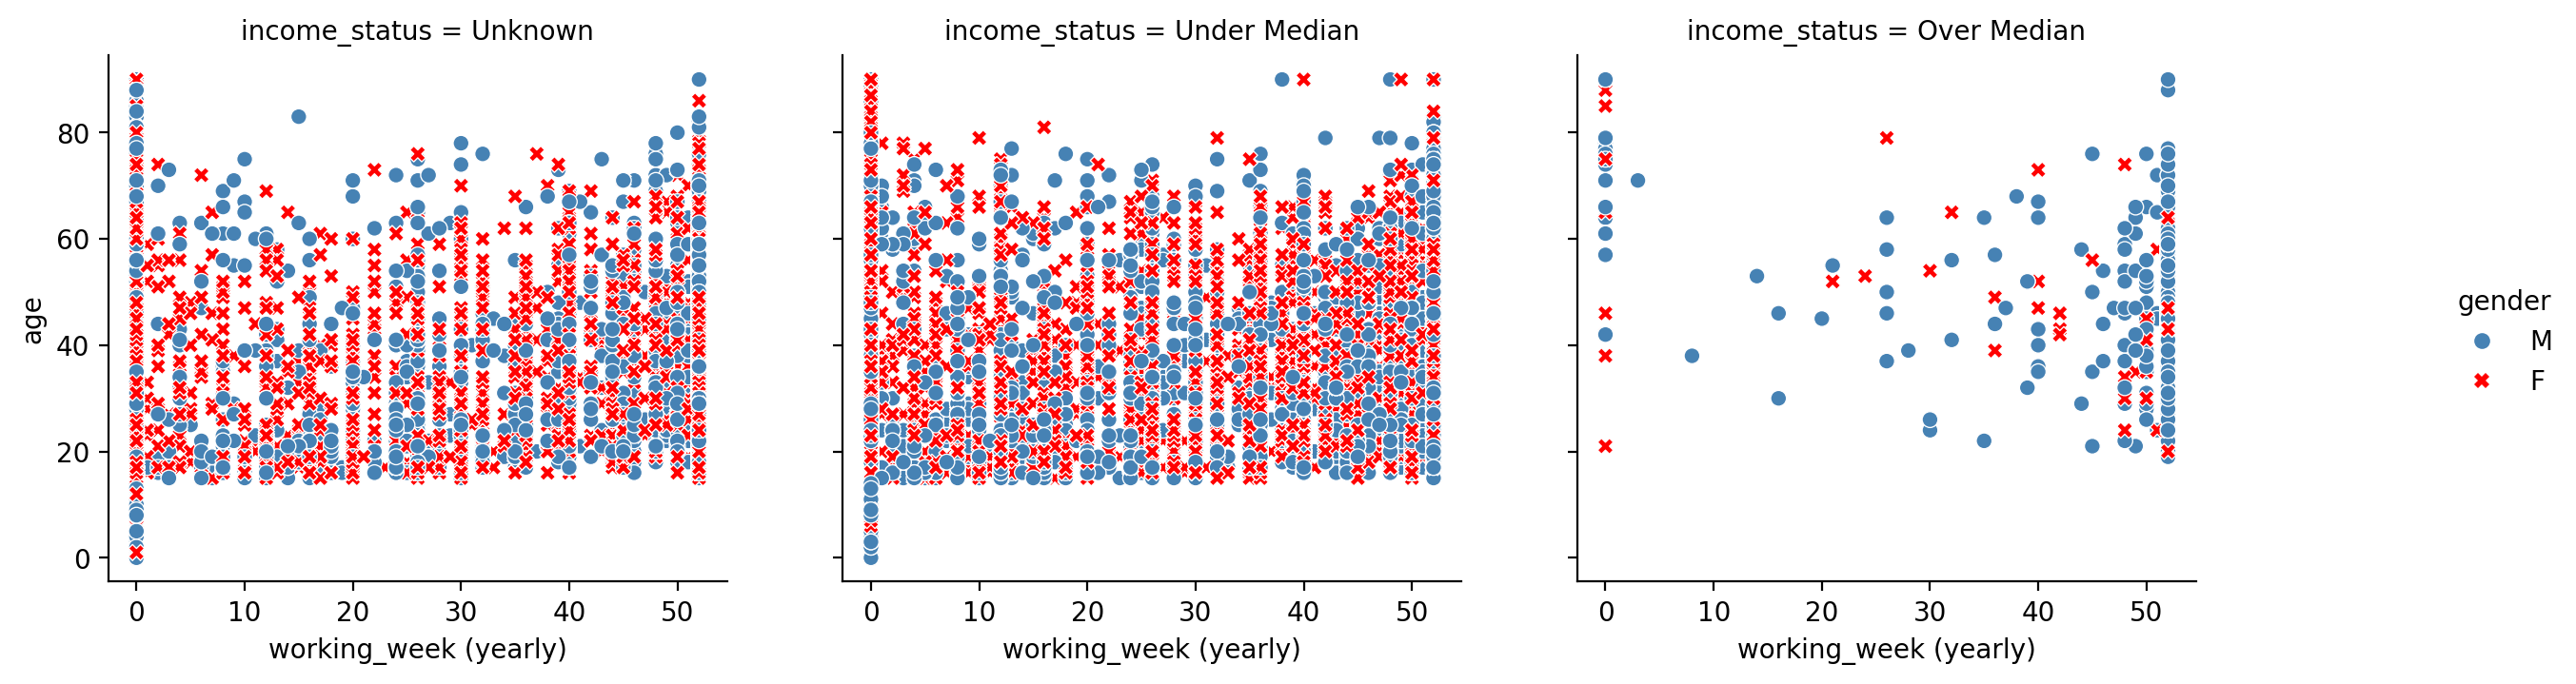

In [40]:
# sns.relplot 통해 상관계수 높은 컬럼들이 income_status, gender에 따라 어떻게 분포가 달라지는지 확인
# 전체적으로 비슷한 모습 보인다

g1 = sns.relplot(data=df,
                 x="working_week (yearly)",
                 y="income",
                 col = "income_status",
                 hue="gender",
                 style="gender", height=3, aspect=.5,
                 palette=["steelblue", "r", "g"])

g2 = sns.relplot(data=df,
                 x="working_week (yearly)",
                 y="age",
                 col = "income_status",
                 hue="gender",
                 style="gender", height=3, aspect=.5,
                 palette=["steelblue", "r", "g"])

g1.fig.set_size_inches(15, 4)
g2.fig.set_size_inches(15, 4)

### Target인 income과 다른 변수들 비교

#### age - income

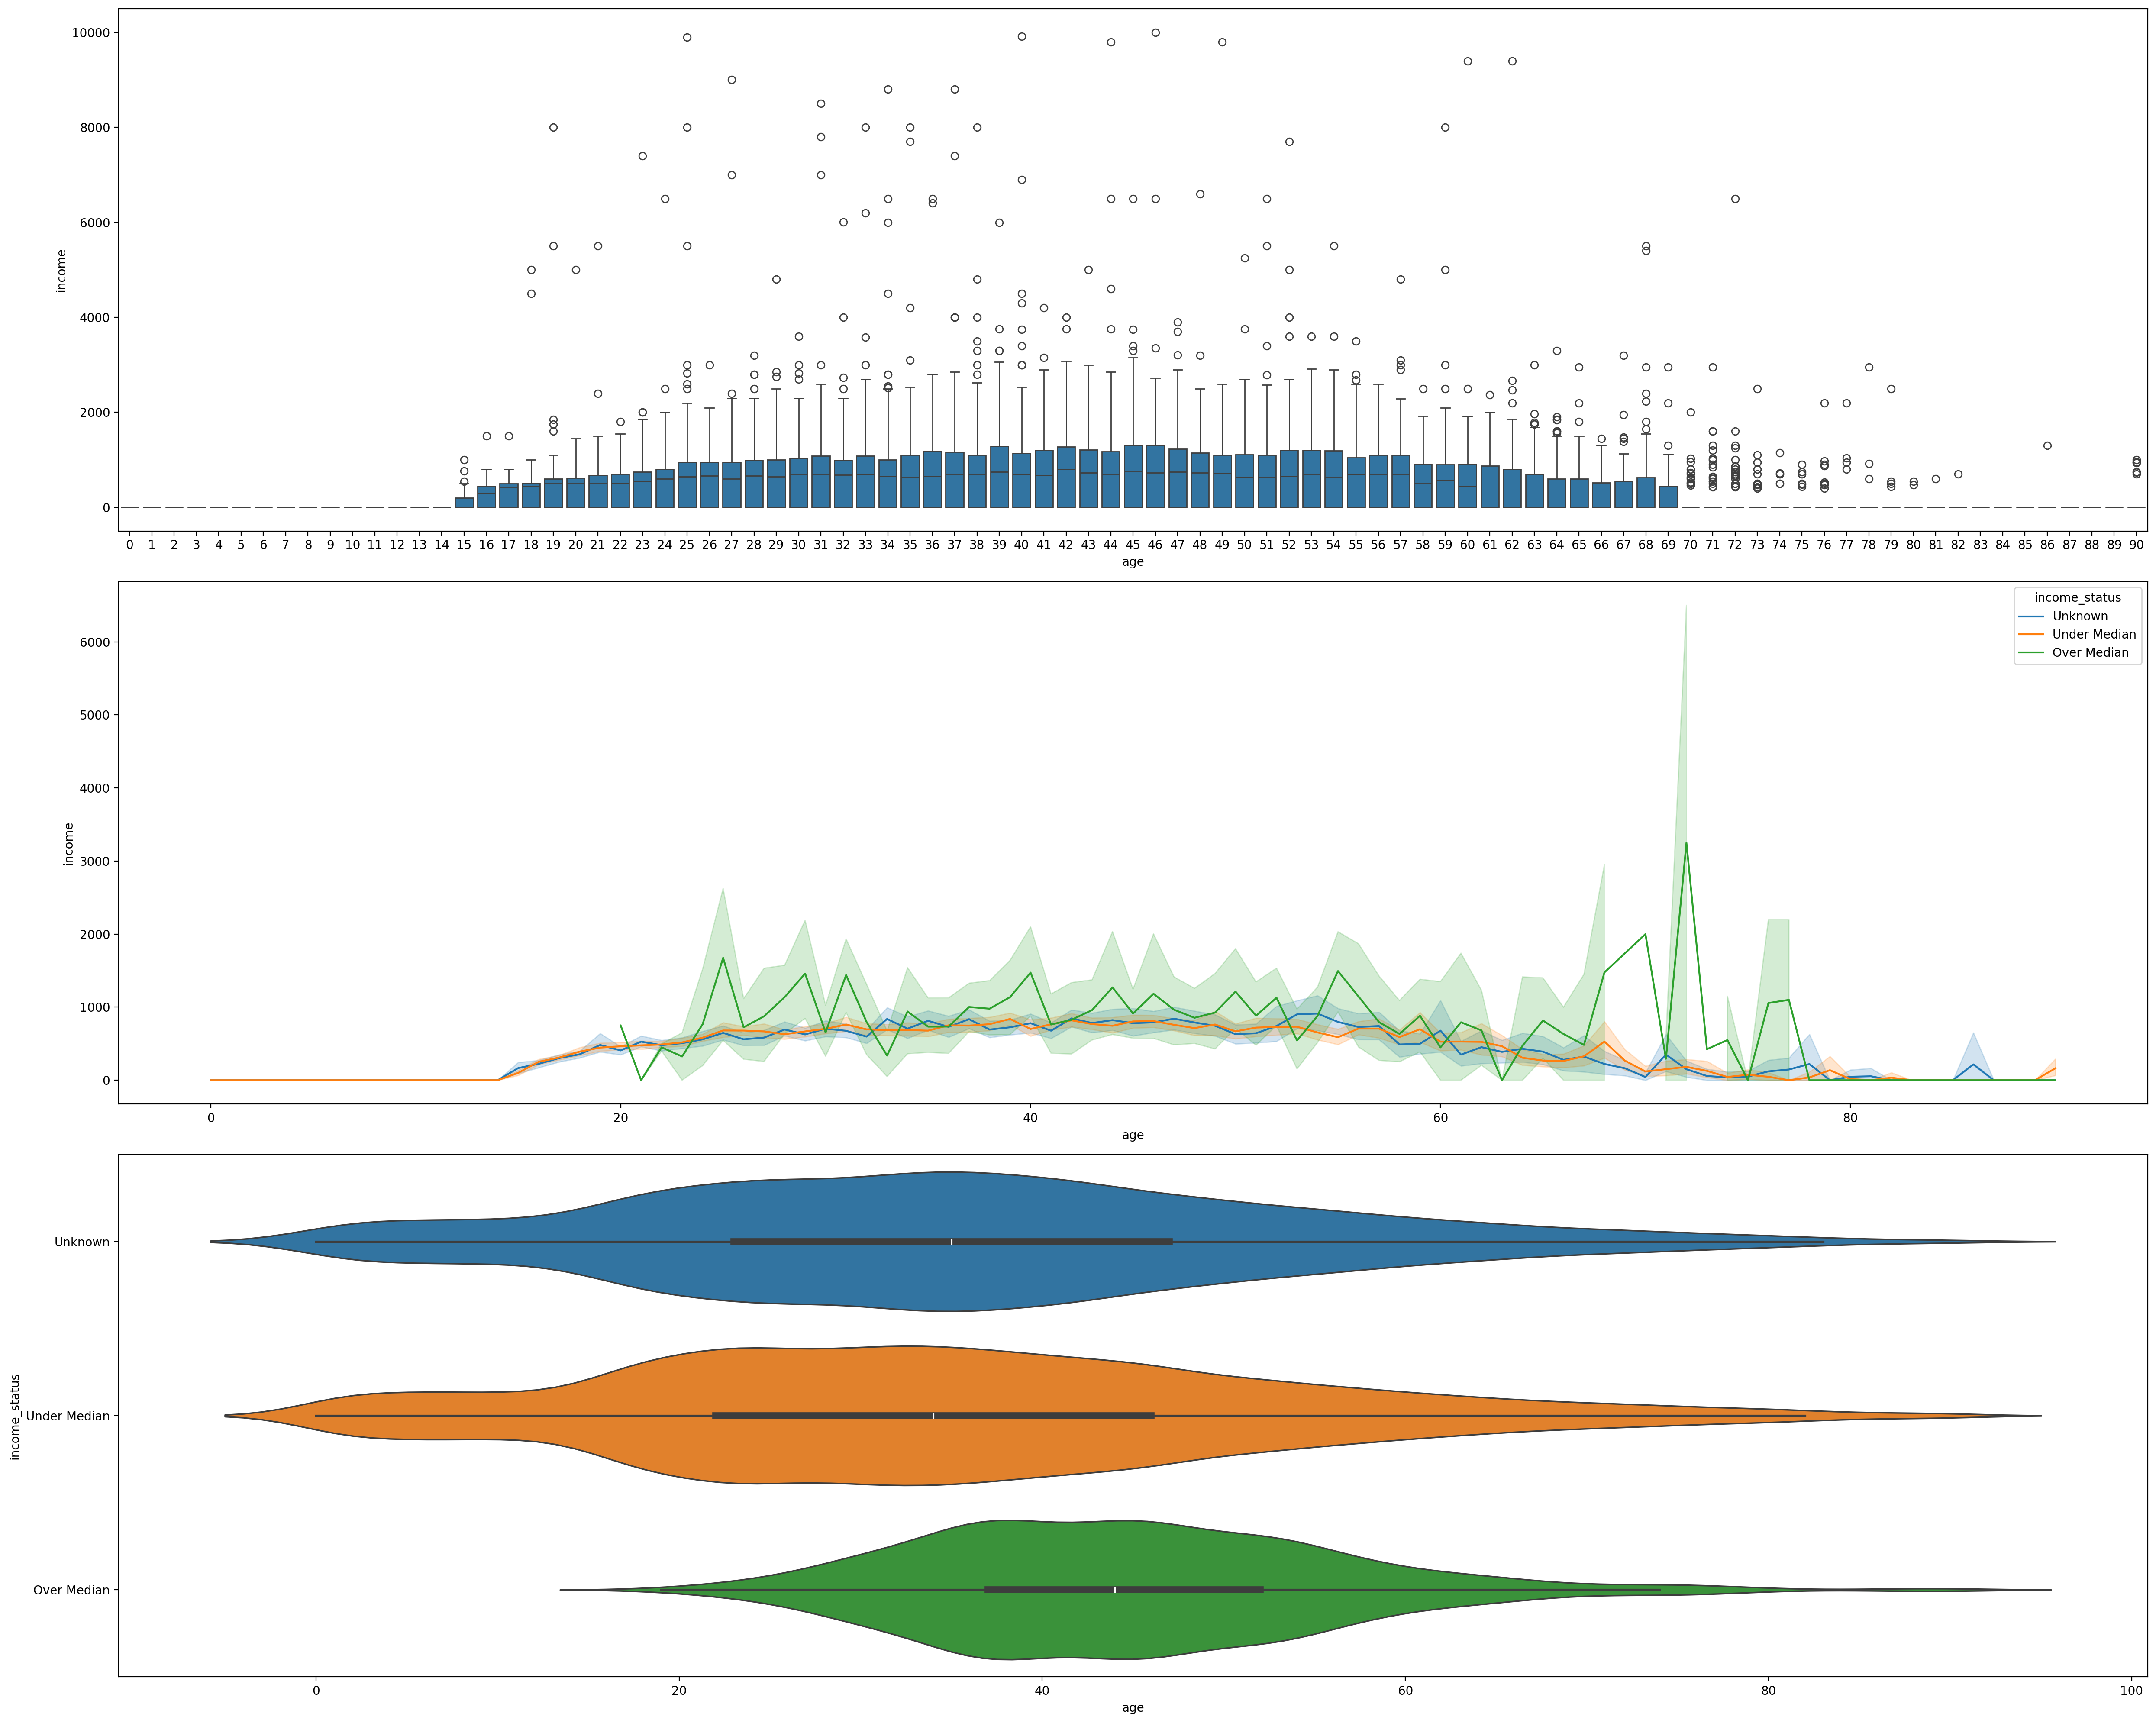

In [41]:
# boxplot 그려서 나이에 따른 골, 어시스트 확인
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25, 20))
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25, 15))

# plt.figure(figsize=(15,8))
g1 = sns.boxplot(data=df, x="age", y="income", ax=axes[0])
g2 = sns.lineplot(data=df, x="age", y="income", hue="income_status", ax=axes[1])
g3 = sns.violinplot(data=df, x="age", y="income_status", hue="income_status", ax=axes[2])
# g3 = sns.boxplot(data=df, x="income", y="income_status", ax=axes[2])

plt.tight_layout()
plt.show()


#### 나머지 컬럼 - income

In [42]:
len(df.columns)

12

In [53]:
df.columns

Index(['age', 'gender', 'education_status', 'working_week (yearly)',
       'occupation_status', 'race', 'hispanic_origin', 'household_summary',
       'citizenship', 'tax_status', 'income_status', 'income'],
      dtype='object')

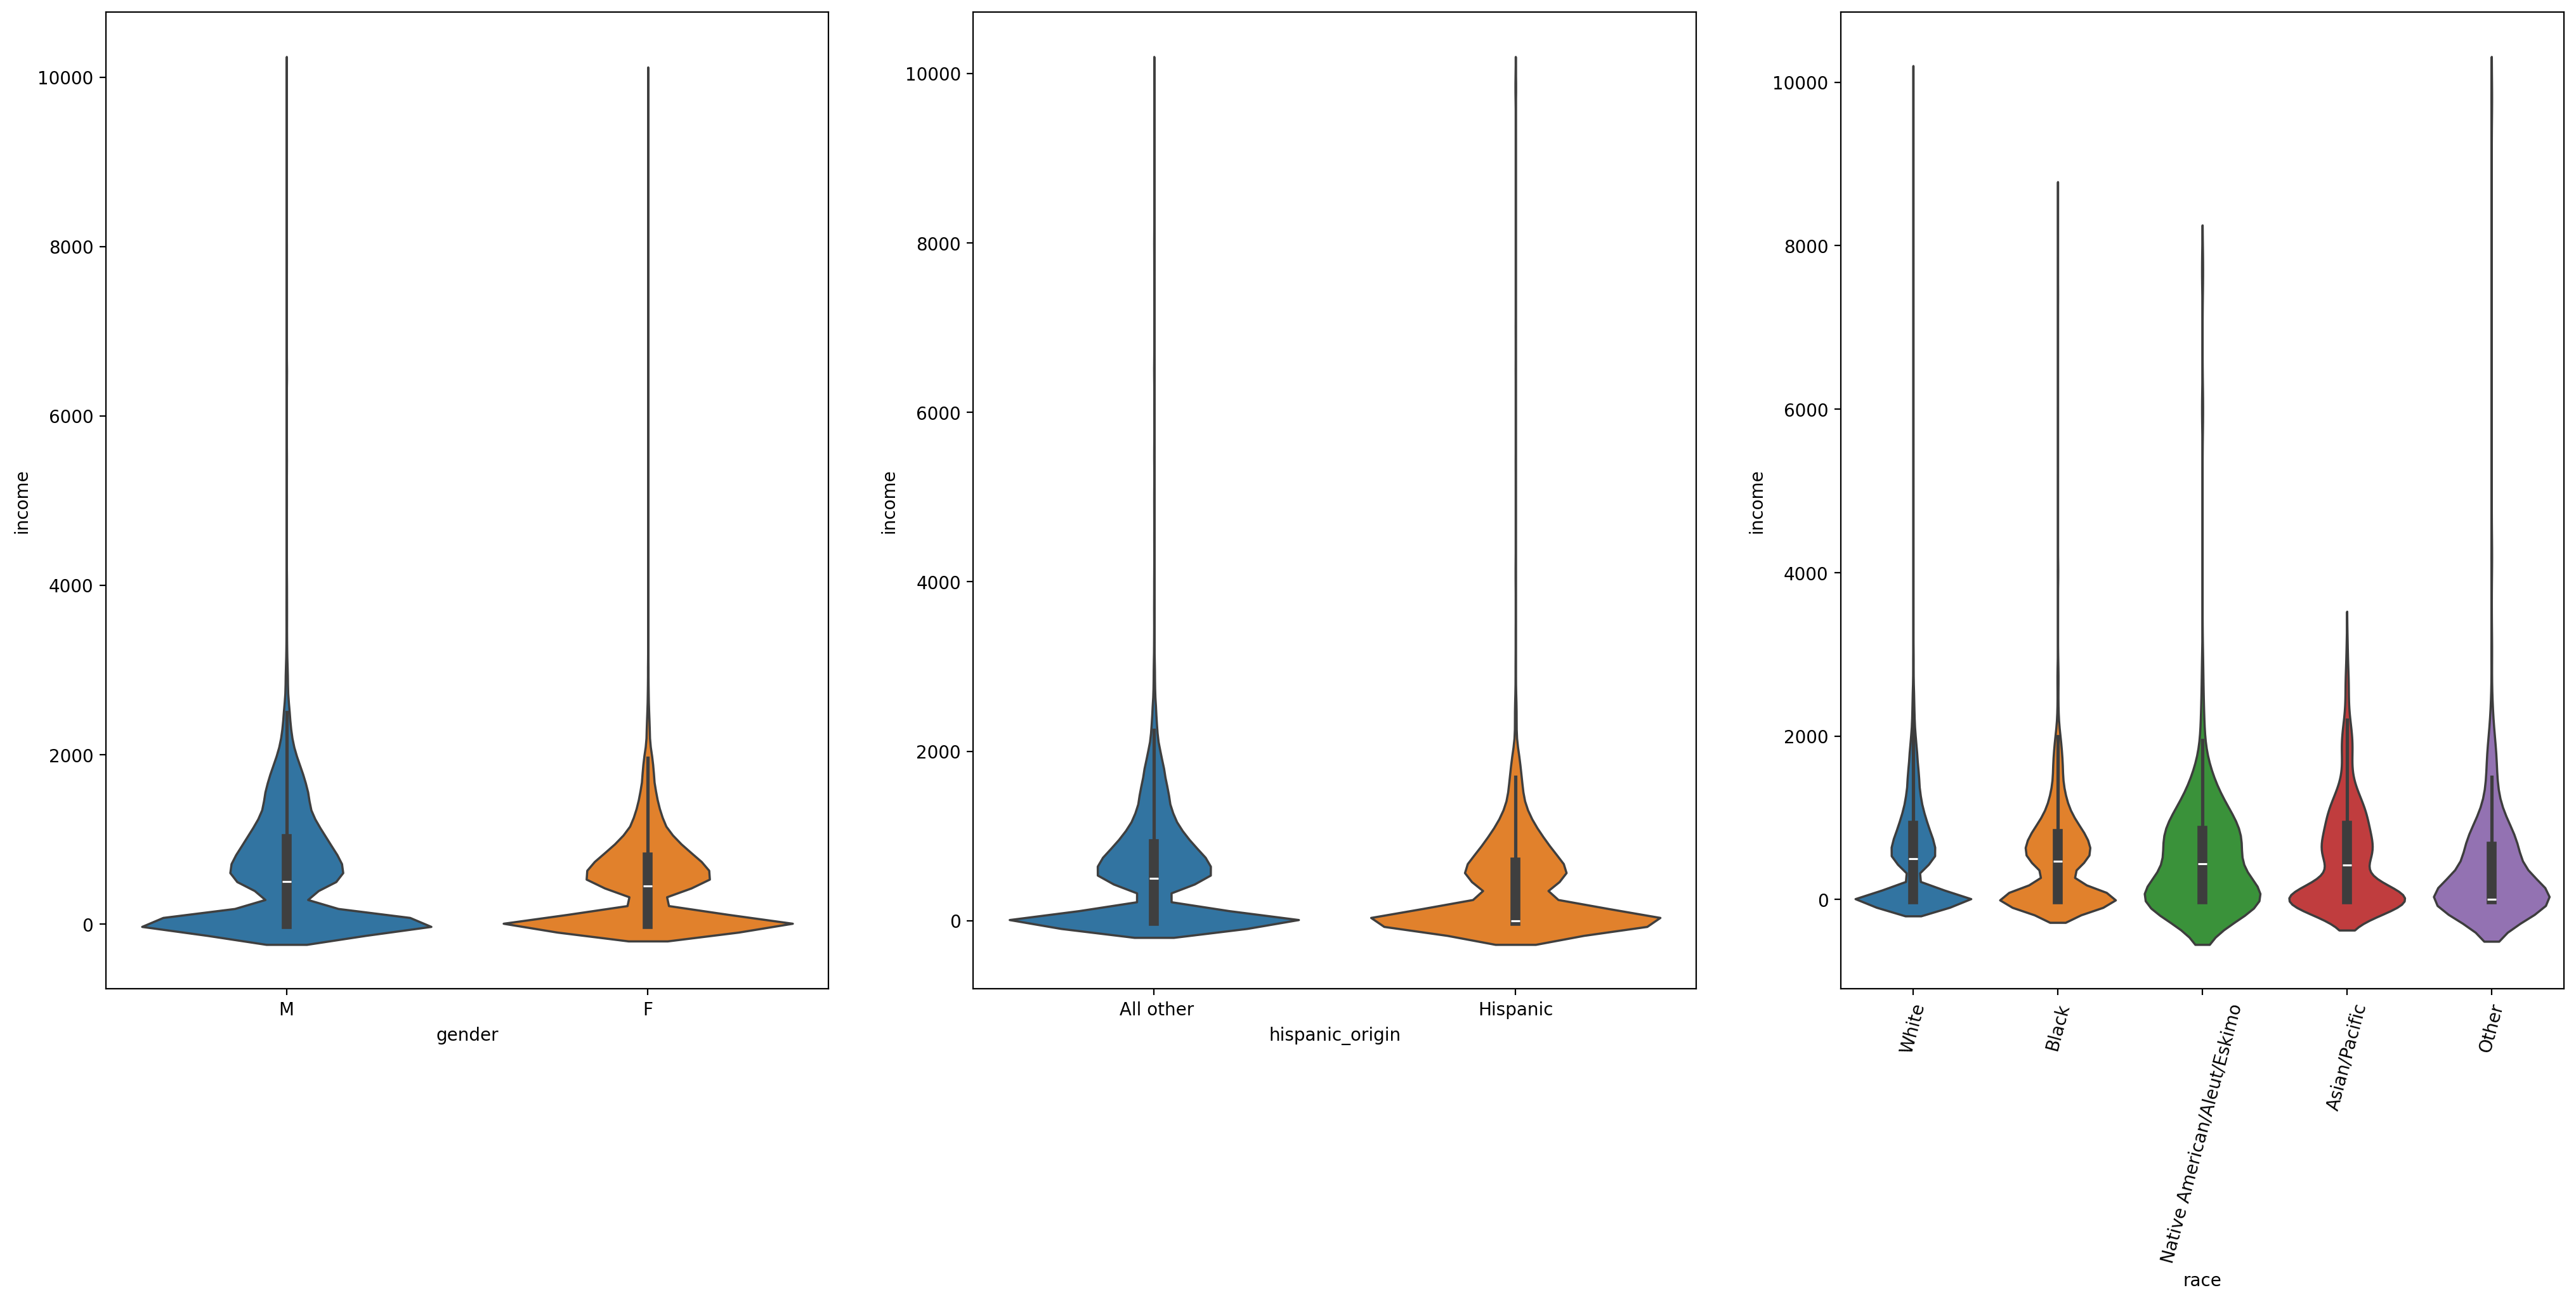

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))

col_etc1 = ["gender", "hispanic_origin", "race"]

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(col_etc1, axes):

    # hue_order = df.groupby(col)['income'].median().sort_values(ascending=False).index.tolist()
    g = sns.violinplot(data=df, x=col, y="income", hue=col, ax=ax)

    if col == "race":
        g.set_xticklabels(g.get_xticklabels(), rotation=75)
    else:
        g.set_xticklabels(g.get_xticklabels())

plt.show()

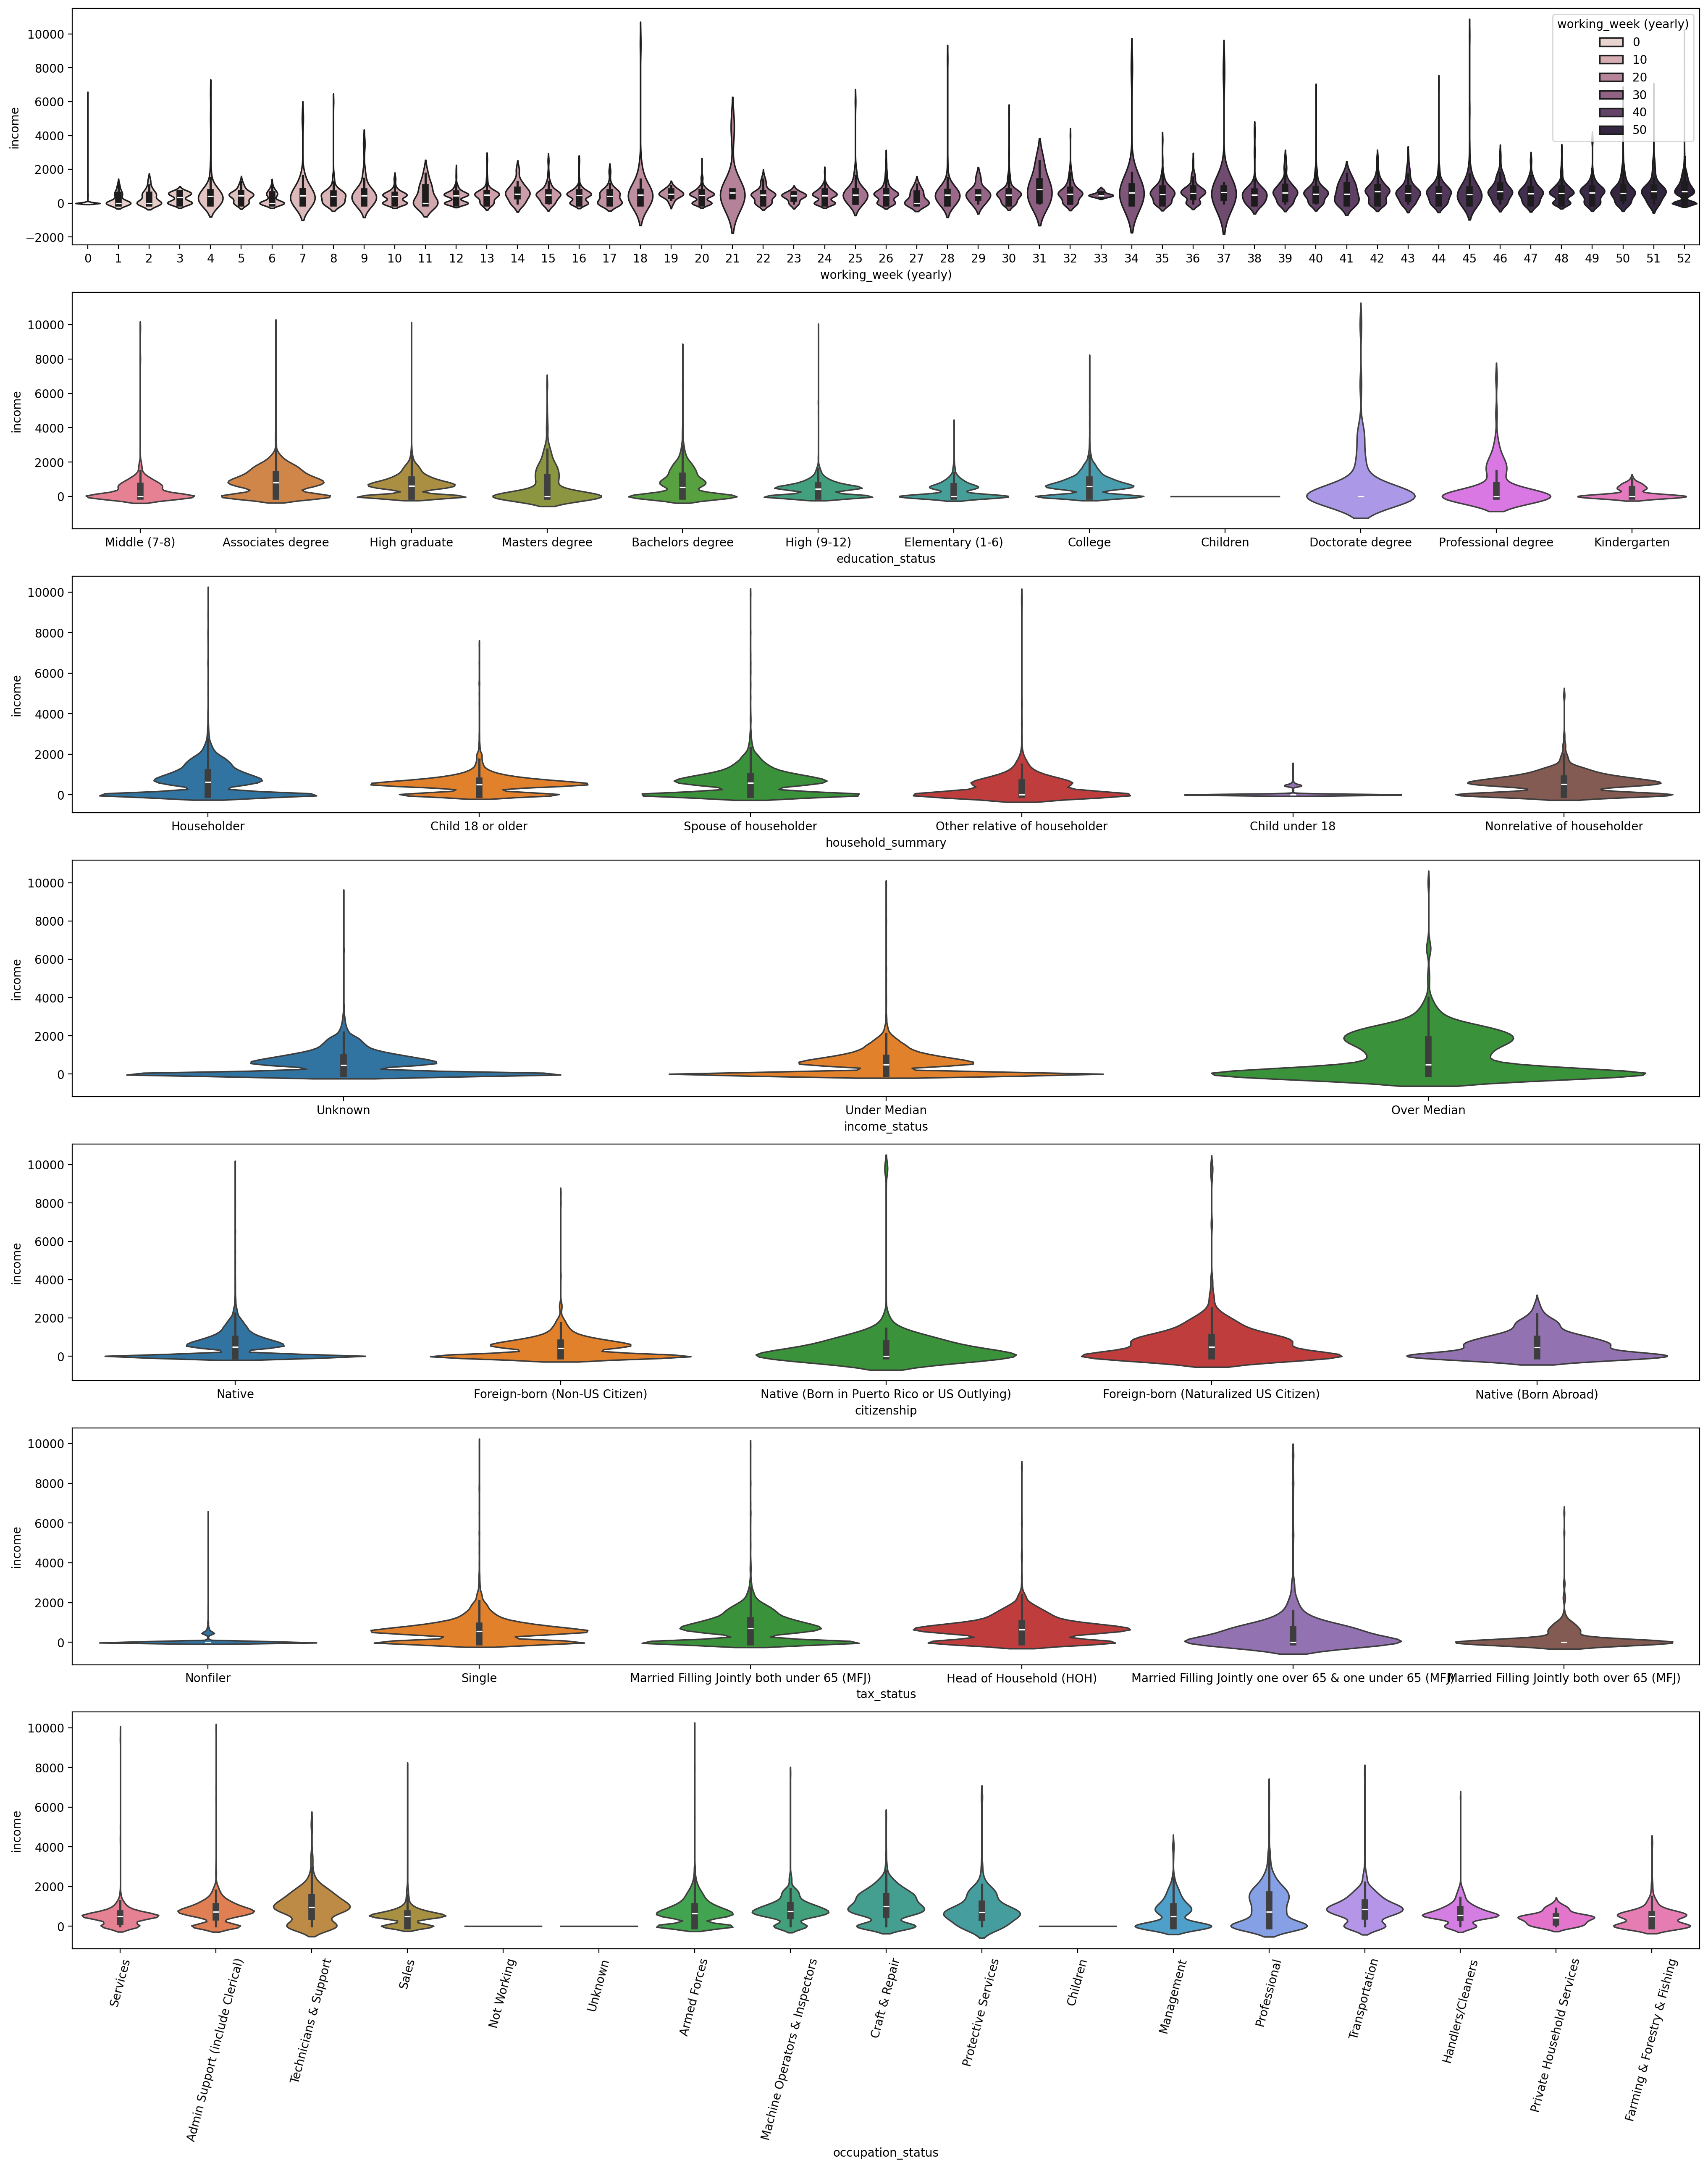

In [60]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(25, 30))

col_etc2 = ["working_week (yearly)", "education_status", "household_summary", "income_status", "citizenship", "tax_status", "occupation_status"]

for col, ax in zip(col_etc2, axes):

    # hue_order = df.groupby(col)['income'].median().sort_values(ascending=False).index.tolist()
    g = sns.violinplot(data=df, x=col, y="income", hue=col, ax=ax)

    if col == "occupation_status":
        g.set_xticklabels(g.get_xticklabels(), rotation=75)
    else:
        g.set_xticklabels(g.get_xticklabels())

plt.show()